In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import random
import os
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### read files

In [4]:
def clean_uniprot_ids_ppi(df):
    df_split = df.assign(uniprot_ids1=df['uniprot_ids1'].str.split('|'),
                     uniprot_ids2=df['uniprot_ids2'].str.split('|'))

    # Explode the lists into multiple rows
    df_exploded = df_split.explode('uniprot_ids1').explode('uniprot_ids2')

    return df_exploded

def clean_uniprot_ids_features(df):
    df_split = df.assign(uniprot_ids=df['uniprot_ids'].str.split('|'))

    # Explode the lists into multiple rows
    df_exploded = df_split.explode('uniprot_ids')

    return df_exploded

In [5]:
# read MOI data
df_ADAR = clean_uniprot_ids_features(pd.read_csv("../data/MOI/df_ADAR_available.tsv.gz", sep="\t"))
df_ADAR

,symbol,uniprot_ids,chr,AD,AR
0,A1CF,Q9NQ94,10,1,1
1,A2ML1,A8K2U0,12,1,0
2,AAAS,Q9NRG9,12,0,1
3,AAGAB,Q6PD74,15,1,0
4,AARS1,P49588,16,1,1
...,...,...,...,...,...
4717,ZP2,Q05996,16,0,1
4718,ZP3,P21754,7,1,0
4719,ZPR1,O75312,11,0,1
4720,ZSWIM6,Q9HCJ5,5,1,0


In [6]:
df_ADAR_notavailable = clean_uniprot_ids_features(pd.read_csv("../data/MOI/df_ADAR_notavailable.tsv.gz", sep="\t"))
df_ADAR_notavailable

,symbol,uniprot_ids,chr,AD,AR
0,A1BG,P04217,19,NaN,NaN
1,A2M,P01023,12,NaN,NaN
2,A3GALT2,U3KPV4,1,NaN,NaN
3,A4GALT,Q9NPC4,22,NaN,NaN
4,A4GNT,Q9UNA3,3,NaN,NaN
...,...,...,...,...,...
13623,ZYG11A,Q6WRX3,1,NaN,NaN
13624,ZYG11B,Q9C0D3,1,NaN,NaN
13625,ZYX,Q15942,7,NaN,NaN
13626,ZZEF1,O43149,17,NaN,NaN


In [7]:
# read PPI
ppi = clean_uniprot_ids_ppi(pd.read_csv("../data/PPI_biogrid_HuRI_Menche_string700.txt", sep=" "))
ppi

,SYMBOL1,SYMBOL2,uniprot_ids1,uniprot_ids2
0,FLNC,MAP2K4,Q14315,P45985
1,FLNC,SGCD,Q14315,Q92629
2,FLNC,SGCG,Q14315,Q13326
3,FLNC,MYOZ1,Q14315,Q9NP98
4,FLNC,KCND2,Q14315,Q9NZV8
...,...,...,...,...
381760,CALM1,CALM2,P0DP23,P0DP24
381761,JAK1,SOCS7,P23458,O14512
381762,JAK1,PIK3CB,P23458,P42338
381763,ADCY7,CAMK2A,P51828,Q9UQM7


In [8]:
# read features
describe_prot = clean_uniprot_ids_features(pd.read_csv("../data/describe_prot.tsv.gz", sep="\t"))
describe_prot

,uniprot_ids,flDPnn_disorder,PSIPRED_helix,PSIPRED_strand,PSIPRED_coil,MMseq2_low_conservation,MMseq2_high_conservation,MMseq2_median,SignalP,DFLpred_linker,ASAquick_buried,DisoRDPbind_RNA,DisoRDPbind_DNA,DisoRDPbind_PRO,MoRFchibi_morf,DRNApred_RNA,DRNApred_DNA,SCRIBER_PRO,PTM_content
0,A0A024R1R8,1.000,0.594,0.000,0.406,0.02,0.08,2.705,0.0,0.000,0.000,0.00,0.406,0.000,0.656,0.266,0.00,0.078,0.109
1,A0A024RBG1,0.271,0.271,0.188,0.541,0.01,0.13,2.810,0.0,0.116,0.265,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.072
2,A0A075B6H5,0.131,0.238,0.308,0.454,0.02,0.12,2.610,1.0,0.062,0.131,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.054
3,A0A075B6H7,0.000,0.164,0.328,0.508,0.02,0.15,2.580,1.0,0.259,0.207,0.00,0.000,0.000,0.000,0.000,0.05,0.000,0.147
4,A0A075B6H8,0.000,0.265,0.222,0.513,0.00,0.17,2.750,1.0,0.068,0.282,0.00,0.000,0.000,0.000,0.000,0.20,0.000,0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20531,V9GZ13,0.540,0.800,0.000,0.200,0.02,0.22,2.695,0.0,0.000,0.000,0.12,0.000,0.000,1.000,0.000,0.54,0.440,0.080
20532,W5XKT8,0.000,0.556,0.133,0.311,0.06,0.11,2.370,0.0,0.006,0.312,0.00,0.000,0.000,0.000,0.000,0.01,0.000,0.034
20533,W6CW81,0.212,0.513,0.062,0.425,0.00,0.09,2.680,0.0,0.133,0.133,0.00,0.000,0.000,0.000,0.000,0.12,0.000,0.124
20534,X5D2U9,0.041,0.316,0.312,0.372,0.00,0.14,2.785,1.0,0.011,0.233,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.045


In [9]:
describe_prot.columns

Index(['uniprot_ids', 'flDPnn_disorder', 'PSIPRED_helix', 'PSIPRED_strand',
       'PSIPRED_coil', 'MMseq2_low_conservation', 'MMseq2_high_conservation',
       'MMseq2_median', 'SignalP', 'DFLpred_linker', 'ASAquick_buried',
       'DisoRDPbind_RNA', 'DisoRDPbind_DNA', 'DisoRDPbind_PRO',
       'MoRFchibi_morf', 'DRNApred_RNA', 'DRNApred_DNA', 'SCRIBER_PRO',
       'PTM_content'],
      dtype='object')

In [10]:
shet_features = clean_uniprot_ids_features(pd.read_csv("../data/shet_selected_features.tsv.gz", sep="\t"))
shet_features

,uniprot_ids,CDS_GC,UTR3_length,UTR3_GC,transcript_length,num_exons,transcript_GC,UTR5_length,UTR5_GC,CDS_length,...,Extracellular,GolgiApparatus,LysosomeOrVacuole,Mitochondrion,Nucleus,Peroxisome,Plastid,MembraneBound,Soluble,UNEECON_G
0,O43657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.098656
1,Q9H2S6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.182126
2,O60762,0.412516,262.0,0.255725,23663.0,9.0,0.398301,9.0,0.666667,0.888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.255389
3,Q8IZE3,0.450411,4082.0,0.376286,44266.0,13.0,0.400330,159.0,0.622642,2.229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.149153
4,Q9NSG2,0.420765,1093.0,0.354986,59041.0,25.0,0.370725,356.0,0.426966,2.562,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.099038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17902,Q14184,0.620662,4652.0,0.568573,38862.0,9.0,0.564459,171.0,0.877193,1.239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
17903,Q8WU43,0.384058,835.0,0.398802,9963.0,4.0,0.423065,516.0,0.507752,0.276,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.134916
17904,Q13224,0.540965,25446.0,0.418180,444266.0,14.0,0.405633,708.0,0.477401,4.455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.676874
17905,Q9Y675,0.532407,371.0,0.342318,13423.0,3.0,0.415108,63.0,0.682540,0.216,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.191191


In [11]:
features_DnGofLofPaper = clean_uniprot_ids_features(pd.read_csv("../data/features_DnGofLofPaper.tsv.gz", sep="\t"))
features_DnGofLofPaper

,uniprot_ids,dn_ds,abundance,exp_var,betweenness,median_scriber,n_paralogs,max_id,shet,nc_gerp,membrane_propensity,efx_raw,efx_abs,aco,pi,strand_pct,helix_pct,pct_buried,plddt,ct
0,P04217,0.281393,1703.000,27771.571936,0.000053,0.0990,25.0,0.243542,0.000502,-1.041153,0.059434,-2.200350,-4.119574,22.958808,5.473445,0.462626,0.000000,0.440404,86.520343,0
1,Q9NQ94,0.262739,3.880,403.367145,0.000186,0.0830,36.0,0.487805,0.016500,2.137678,0.517310,-4.807986,-10.895981,12.649005,9.083333,0.188552,0.208754,0.276094,69.012778,0
2,P01023,NaN,1764.000,76530.887282,0.000131,0.0630,8.0,0.717096,0.010068,0.702367,0.401971,-2.007261,-4.003098,52.662712,6.253608,0.391452,0.140434,0.518318,82.030149,0
3,A8K2U0,0.336245,4.560,6760.359221,0.000035,0.0590,8.0,0.351444,0.000361,-0.090234,0.056678,-1.956738,-3.768817,52.418667,5.491150,0.392022,0.145805,0.521320,80.948177,0
4,U3KPV4,0.406874,0.000,0.008581,0.000018,0.1300,3.0,0.338235,0.001066,-0.382439,0.124294,-2.870083,-4.546424,27.784167,10.955319,0.147059,0.352941,0.517647,90.760618,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20360,Q6WRX3,0.598997,0.322,0.497987,0.000015,0.0925,2.0,0.000000,0.000405,-0.437928,0.063729,-2.799698,-4.661322,13.115206,9.033270,0.044796,0.525692,0.519104,90.445138,0
20361,Q9C0D3,0.066092,0.816,152.357502,0.000068,0.1180,2.0,0.596774,0.154437,0.774037,0.049745,-3.132392,-5.204659,12.288397,6.596195,0.048387,0.534946,0.537634,92.442863,1
20362,Q15942,0.083230,239.000,12614.114609,0.000123,0.1260,1.0,0.000000,0.008041,0.406220,-0.027150,-4.641151,-11.855881,17.309842,6.371462,0.080420,0.103147,0.131119,62.941014,0
20363,O43149,0.181384,3.640,19.334703,0.000114,0.0180,0.0,0.000000,0.057000,0.009405,0.026494,-1.638749,-4.060054,25.580570,5.582886,0.104357,0.441067,0.410672,75.916846,0


In [12]:
domino_features = clean_uniprot_ids_features(pd.read_csv("../data/domino_features.tsv.gz", sep="\t"))
domino_features

,uniprot_ids,phylop_5utr,ExAC_don_to_syn,mRNA_halflife_10
0,P04217,-0.065900,0.010870,0
1,Q9NQ94,0.354861,0.000000,0
2,P01023,0.115622,0.009524,1
3,A8K2U0,0.133771,0.069959,0
4,U3KPV4,0.136512,0.038461,0
...,...,...,...,...
17373,Q6WRX3,0.024796,0.057143,0
17374,Q9C0D3,0.842005,0.000000,0
17375,Q15942,0.436891,0.009091,0
17376,O43149,0.665234,0.009960,0


In [13]:
gnomadv4_constraints = clean_uniprot_ids_features(pd.read_csv("../data/gnomadv4_constraints.tsv.gz", sep="\t"))
gnomadv4_constraints

,uniprot_ids,lof.pLI,lof.pNull,lof.pRec,lof.oe_ci.upper,mis.z_score,syn.z_score
0,P04217,1.770600e-16,0.842950,0.15705,1.340,-0.86092,-0.635490
1,Q9NQ94,7.656000e-10,0.001961,0.99804,0.825,1.23730,0.017838
2,P01023,9.756800e-20,0.000010,0.99999,0.765,2.75870,1.836200
3,A8K2U0,1.712700e-40,0.101100,0.89890,0.953,1.65710,0.951210
4,U3KPV4,1.016900e-06,0.424980,0.57502,1.529,-4.07990,-3.997000
...,...,...,...,...,...,...,...
17886,A0A1B0GTJ6,1.332200e-03,0.332020,0.66665,1.843,-0.12558,-0.270880
17887,X6R8R1,8.079800e-01,0.012984,0.17903,0.679,2.33740,2.093100
17888,A0A1W2PQ72,7.549600e-07,0.107530,0.89247,1.089,1.58890,0.390280
17889,A0A494BZU4,NaN,NaN,NaN,NaN,-0.03599,1.104800


In [14]:
go_protein_embeds = clean_uniprot_ids_features(pd.read_csv("../data/go_protein_embeds.tsv.gz", sep="\t"))
go_protein_embeds

,uniprot_ids,go1,go2,go3,go4,go5,go6,go7,go8,go9,...,go247,go248,go249,go250,go251,go252,go253,go254,go255,go256
0,Q96E09,-0.240532,0.199093,0.228713,-0.163348,-0.289355,-0.273817,0.061789,0.043553,-0.096713,...,-0.004356,0.004354,-0.191943,-0.135097,0.496563,-0.037142,-0.113641,0.247854,0.592022,-0.126789
1,Q8NHS2,0.039036,0.103110,-0.077873,-0.209144,0.146635,0.034035,-0.024490,0.105680,-0.041133,...,0.073998,0.080049,0.141890,-0.019078,-0.282809,-0.053632,0.088758,0.069089,-0.100444,0.359954
2,P78537,-0.349201,-0.155750,0.099971,-0.247121,0.791519,0.120000,0.016672,0.774661,-0.026834,...,-0.046683,0.181079,-0.025409,-0.811796,0.353496,0.210930,-0.308465,0.071470,0.198182,-0.191897
3,Q96P50,-0.074946,0.032057,0.007903,-0.006401,-0.095199,0.099010,-0.227483,0.200370,-0.119252,...,0.050728,-0.219550,-0.368998,0.058938,-0.197703,0.031391,-0.364904,0.280781,0.080630,-0.279411
4,P10828,-0.462079,-0.488158,0.047528,-0.005784,0.036835,-0.301946,-0.176819,-0.468762,-0.457208,...,0.093086,-0.089993,-0.178483,-0.193738,0.191996,-0.504364,-0.439687,-0.120813,-0.112334,-0.454890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13803,P78352,0.129119,-0.088599,0.653012,-0.098262,-0.056059,-0.438094,-0.399279,0.731592,-0.785625,...,0.268693,-0.143152,-0.037795,-0.192091,-0.753132,-0.420467,-0.611471,0.490372,0.494016,0.764688
13804,P01040,-0.158891,-0.081889,0.172119,-0.232751,-0.220431,0.008246,0.043538,-0.167147,-0.312714,...,0.339443,0.230910,0.176103,0.365903,-0.192748,0.191416,-0.023618,-0.076266,0.189607,-0.276301
13805,Q9UMX5,0.366623,0.019302,0.007734,0.181714,-0.092024,-0.038810,-0.082953,0.068937,-0.002832,...,-0.077021,0.207809,0.010356,0.081162,-0.161691,-0.062679,0.000977,-0.203003,0.045667,-0.089480
13806,Q9P258,-0.063953,0.041213,0.028028,-0.022290,-0.477627,-0.005918,0.308079,-0.040447,0.354176,...,-0.141519,-0.413011,0.327587,0.412700,0.096597,0.452873,0.116137,0.025886,-0.043770,-0.194594


In [15]:
archs_protein_embeds = clean_uniprot_ids_features(pd.read_csv("../data/archs_protein_embeds.tsv.gz", sep="\t"))
archs_protein_embeds

,uniprot_ids,archs1,archs2,archs3,archs4,archs5,archs6,archs7,archs8,archs9,...,archs247,archs248,archs249,archs250,archs251,archs252,archs253,archs254,archs255,archs256
0,P02775,-0.219830,-0.303388,-0.047050,0.237550,-0.069661,-0.309966,-0.112000,-0.169067,0.186490,...,0.015242,-0.006826,0.138376,0.239935,0.338778,0.073836,-0.171387,0.081760,-0.248808,0.154490
1,O60667,0.137531,0.205124,0.280698,0.161857,-0.245193,-0.135198,-0.053000,-0.148115,0.231300,...,0.356448,-0.181253,0.076302,0.171204,0.212244,-0.100621,-0.057713,0.018387,-0.339721,0.219789
2,Q96P31,-0.077495,0.241766,0.116419,0.509376,-0.064415,0.089058,-0.082627,-0.555832,0.001400,...,0.022217,-0.236002,-0.294772,0.254300,0.497920,-0.279438,-0.137529,0.281407,-0.199422,0.168712
3,P04141,-0.005147,-0.453250,-0.065534,0.100561,-0.158955,-0.129750,0.059528,-0.172797,-0.322244,...,-0.170054,0.042440,-0.052973,-0.042502,0.058253,-0.285861,-0.321326,-0.270113,-0.207982,0.023916
4,P09919,-0.648207,-0.591656,-0.152066,0.322753,-0.307761,-0.130773,-0.045817,-0.055363,0.173881,...,0.072737,-0.173995,-0.264823,0.009411,0.023192,0.171449,0.108463,-0.389837,-0.054556,0.160692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16237,Q7Z602,-0.181025,0.143512,-0.219390,-0.075869,-0.336303,0.028499,0.310462,0.245972,-0.341492,...,0.090077,-0.093488,-0.163793,0.270308,0.161727,0.133965,0.039151,0.406289,0.002772,0.112363
16238,O95427,-0.027178,-0.234328,-0.084866,-0.078417,-0.021471,-0.339155,-0.000025,-0.164298,0.196472,...,0.227954,-0.210143,0.174732,0.117903,-0.139497,0.000862,0.023311,-0.030688,-0.170405,-0.304666
16239,A8MWA6,-0.140649,-0.224337,-0.337660,0.177727,0.372136,-0.019965,-0.101801,0.319645,-0.349637,...,-0.168976,0.197443,0.011841,0.338085,-0.116126,-0.114875,-0.087184,-0.028148,0.003357,-0.196080
16240,Q8NF64,-0.144212,-0.098214,-0.077809,-0.302963,-0.219117,-0.463846,0.365976,-0.325829,0.287956,...,-0.009282,-0.160374,0.588061,-0.335711,0.020058,-0.353474,-0.183843,0.268614,-0.047568,-0.350903


In [16]:
omics_embeds = clean_uniprot_ids_features(pd.read_csv("../data/omics_embeds.tsv.gz", sep="\t"))
omics_embeds

,uniprot_ids,OMICS_EMB_0,OMICS_EMB_1,OMICS_EMB_2,OMICS_EMB_3,OMICS_EMB_4,OMICS_EMB_5,OMICS_EMB_6,OMICS_EMB_7,OMICS_EMB_8,...,OMICS_EMB_246,OMICS_EMB_247,OMICS_EMB_248,OMICS_EMB_249,OMICS_EMB_250,OMICS_EMB_251,OMICS_EMB_252,OMICS_EMB_253,OMICS_EMB_254,OMICS_EMB_255
0,O43657,-1.193790,-0.038485,0.477347,-1.355883,-1.283844,0.577406,-0.085741,-0.141601,0.929133,...,1.202038,-0.015473,0.732149,-0.470897,0.163932,0.514095,-1.121097,0.353111,-0.375309,0.271749
1,Q9H2S6,-0.678243,-0.082044,0.628727,-0.036960,-0.327301,-0.132137,-0.658378,0.382881,0.321670,...,0.158936,1.025258,-0.944454,-0.110598,0.059320,-0.250677,-0.524779,-0.302290,0.627002,0.164144
2,O60762,0.763473,0.029731,0.157848,-1.063333,-1.121445,0.855230,0.054342,0.782584,0.679390,...,0.215326,-0.662693,0.154820,0.359877,-0.675248,-0.293355,-0.355871,0.380746,-0.834603,-0.782095
3,Q8IZE3,0.500445,0.107114,0.758035,-1.097068,0.355529,0.676653,0.562473,-0.585225,0.680695,...,-0.443879,0.226092,0.258948,0.716421,0.022804,-0.488464,-0.700852,-0.285765,0.137165,-0.220267
4,Q9NSG2,0.085451,0.300662,-0.520867,-0.111104,0.116884,1.271965,0.750282,-0.769611,0.652003,...,-0.781987,-0.538280,-1.022490,-0.261985,-0.225361,0.223187,-0.840165,1.048801,-0.219930,-0.667091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18721,A0A096LPK9,-1.285762,-0.532386,0.472166,-0.289166,-0.054351,0.733982,-0.032010,0.458600,0.186043,...,-0.820084,-0.449781,0.334891,0.314113,-0.159055,0.030284,0.080044,-0.448090,-0.852289,0.147231
18722,P0DN26,-0.352910,-0.629301,0.657030,0.038808,-0.044118,0.510875,0.295417,1.206252,-0.483026,...,-0.355055,-0.183311,0.341001,0.182118,-0.849805,0.448570,0.775841,-0.988211,-0.040179,-0.623543
18723,Q5VWM3,-0.747952,0.189803,0.726801,-0.545487,0.655959,0.632166,0.310784,0.473277,-0.434502,...,-0.428722,-0.579665,-0.553515,0.872780,-0.595741,-0.342965,-0.094346,-0.198995,0.092503,-0.682492
18724,Q8N6Y1,0.370369,0.544673,0.038521,-0.076205,-0.198006,-1.181651,-1.710921,0.237358,0.539198,...,0.184846,0.552963,0.504401,0.176097,0.356096,0.734804,-0.013792,0.278445,0.502583,-0.770687


### create graph

In [17]:
# Create a PPI graph using networkx
G = nx.Graph()
node_idx_map = {}  # To store mapping between uniprot_ids and node indices
idx = 0

for index, row in ppi.iterrows():
    u1, u2 = row['uniprot_ids1'], row['uniprot_ids2']
    
    # Add nodes with unique indices
    if u1 not in node_idx_map:
        node_idx_map[u1] = idx
        idx += 1
    if u2 not in node_idx_map:
        node_idx_map[u2] = idx
        idx += 1
    
    # Add edge to the graph
    G.add_edge(node_idx_map[u1], node_idx_map[u2])

# Convert the PPI graph to a PyTorch Geometric graph
data = from_networkx(G)

# The graph is now in PyTorch Geometric format
print(data)


Data(edge_index=[2, 750988], num_nodes=17248)


In [18]:
# add labels
num_nodes = data.num_nodes
labels = torch.full((num_nodes, 2), -1.0)  # -1 indicates no label (for unlabeled nodes)

# Add labels for nodes present in the graph
for index, row in df_ADAR.iterrows():
    uniprot_id = row['uniprot_ids']
    if uniprot_id in node_idx_map:  # Check if the node is in the graph
        node_idx = node_idx_map[uniprot_id]
        labels[node_idx, 0] = row['AD']
        labels[node_idx, 1] = row['AR']

# Add labels to the PyTorch Geometric data object
data.y = labels

In [19]:
# add features (describe_prot, shet_features, features_DnGofLofPaper, domino_features, gnomadv4_constraints,
#               go_protein_embeds, archs_protein_embeds, omics_embeds)
import torch

# Merge all feature dataframes on 'uniprot_ids'
merged_features = describe_prot.set_index('uniprot_ids')
merged_features = merged_features.join(shet_features.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.join(features_DnGofLofPaper.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.join(domino_features.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.join(gnomadv4_constraints.set_index('uniprot_ids'), how='outer')
#merged_features = merged_features.join(go_protein_embeds.set_index('uniprot_ids'), how='outer')
#merged_features = merged_features.join(archs_protein_embeds.set_index('uniprot_ids'), how='outer')
#merged_features = merged_features.join(omics_embeds.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.drop('betweenness', axis=1) #this comes from PPI so no need
merged_features

,flDPnn_disorder,PSIPRED_helix,PSIPRED_strand,PSIPRED_coil,MMseq2_low_conservation,MMseq2_high_conservation,MMseq2_median,SignalP,DFLpred_linker,ASAquick_buried,...,ct,phylop_5utr,ExAC_don_to_syn,mRNA_halflife_10,lof.pLI,lof.pNull,lof.pRec,lof.oe_ci.upper,mis.z_score,syn.z_score
uniprot_ids,,,,,,,,,,,,,,,,,,,,,
A0A024R1R8,1.000,0.594,0.000,0.406,0.02,0.08,2.705,0.0,0.000,0.000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A024RBG1,0.271,0.271,0.188,0.541,0.01,0.13,2.810,0.0,0.116,0.265,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A024RCN7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6H5,0.131,0.238,0.308,0.454,0.02,0.12,2.610,1.0,0.062,0.131,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,0.000,0.164,0.328,0.508,0.02,0.15,2.580,1.0,0.259,0.207,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5XKT8,0.000,0.556,0.133,0.311,0.06,0.11,2.370,0.0,0.006,0.312,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W6CW81,0.212,0.513,0.062,0.425,0.00,0.09,2.680,0.0,0.133,0.133,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X5D2U9,0.041,0.316,0.312,0.372,0.00,0.14,2.785,1.0,0.011,0.233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
protein_structure_and_function = {
    'PSIPRED_helix': 'Prediction of helical secondary structures.',
    'PSIPRED_strand': 'Prediction of beta-strand secondary structures.',
    'ASAquick_buried': 'Prediction of buried surface area (solvent accessibility).',
    'flDPnn_disorder': 'Prediction of intrinsically disordered regions.',
    'MoRFchibi_morf': 'Prediction of molecular recognition features (MoRFs).',
    'DFLpred_linker': 'Prediction of disordered flexible linker residues.',
    'DisoRDPbind_RNA': 'Prediction of RNA-binding disordered regions.',
    'DisoRDPbind_DNA': 'Prediction of DNA-binding disordered regions.',
    'DisoRDPbind_PRO': 'Prediction of protein-binding disordered regions.',
    'DRNApred_RNA': 'Prediction of RNA-binding residues.',
    'DRNApred_DNA': 'Prediction of DNA-binding residues.',
    'SignalP': 'Prediction of signal peptides.',
    'SCRIBER_PRO': 'Prediction of protein-binding residues.',
    'PTM_content': 'Prediction of post-translational modification sites.',
    'membrane_propensity': 'Propensity for membrane association.',
    'Plastid': 'Localization to plastid.',
    'CellMembrane': 'Localization to cell membrane.',
    'Cytoplasm': 'Localization to cytoplasm.',
    'EndoplasmicReticulum': 'Localization to endoplasmic reticulum.',
    'Extracellular': 'Localization to extracellular space.',
    'GolgiApparatus': 'Localization to Golgi apparatus.',
    'LysosomeOrVacuole': 'Localization to lysosome or vacuole.',
    'Mitochondrion': 'Localization to mitochondrion.',
    'Nucleus': 'Localization to nucleus.',
    'Peroxisome': 'Localization to peroxisome.',
    'MembraneBound': 'Membrane-bound proteins.',
    'aco': 'Absolute contact order of the protein structure.',
    'pct_buried': 'Fraction of buried residues in protein structure.',
    'plddt': 'Mean pLDDT confidence score of predicted structures.',
    'pi': 'Protein isoelectric point.',
    'ct': 'Cotranslational assembly annotations.',
    'efx_abs': 'Median ratio of ESM-1v and absolute FoldX ΔΔG for missense mutations.',
    'efx_raw': 'Median ratio of ESM-1v and raw FoldX ΔΔG for missense mutations.',
    'median_scriber': 'Median SCRIBER score for residues with more than 5% relative solvent accessible surface area.'
}

evolutionary_conservation_and_variation = {
    'MMseq2_low_conservation': 'Low conservation from MMseqs.',
    'MMseq2_high_conservation': 'High conservation from MMseqs.',
    'phastCons7way_mean': 'Mean conservation score across 7 species.',
    'phastCons7way_max': '95th percentile conservation score across 7 species.',
    'phastCons17way_max': '95th percentile conservation score across 17 species.',
    'phastCons100way_max': '95th percentile conservation score across 100 species.',
    'fracCdsPhylopAm': 'Fraction of coding sequences constrained in 240 mammals.',
    'dn_ds': 'Human-macaque dN/dS ratio of nonsynonymous to synonymous substitutions.',
    'UNEECON_G': 'Evolutionary pressure score (UNEECON).',
    'n_paralogs': 'Number of paralogous proteins.',
    'max_id': 'Maximum sequence identity to paralogs.',
    'nc_gerp': 'GERP++ score for non-coding regions.',
    'phylop_5utr': 'Evolutionary conservation of 5\' UTR.',
    'ExAC_don_to_syn': 'Donor to synonymous mutation ratio from ExAC.',
    'lof.pLI': 'Probability of being loss-of-function intolerant.',
    'lof.pNull': 'Null hypothesis for loss-of-function.',
    'lof.pRec': 'Probability of intolerance to homozygous but not heterozygous loss-of-function variants.',
    'lof.oe_ci.upper': 'Upper confidence interval for loss-of-function over-expected score.',
    'shet': 'Selection coefficient related to heterozygosity.',
    'mis.z_score': 'Z-score for missense variation constraint.',
    'syn.z_score': 'Z-score for synonymous variation constraint.'
}


transcripts_expression_regulation = {
    'abundance': 'Protein abundance (from PaxDB).',
    'exp_var': 'RNA expression variance across tissues.',
    'tau': 'Tissue specificity of gene expression (0, broadly expressed to 1, tissue specific).',
    'TF': 'Indicates if the gene is a transcription factor.',
    'EDS': 'Enhancer domain score.',
    'ABC_count1': 'Number of biosamples with an active ABC enhancer.',
    'ABC_count2': 'Total number of ABC enhancers across all biosamples.',
    'ABC_count3': 'Total number of ABC enhancers after union of enhancer domains.',
    'ABC_length_per_type': 'Average ABC enhancer length per active cell type.',
    'Roadmap_count1': 'Number of biosamples with an active Roadmap enhancer.',
    'Roadmap_count2': 'Total number of Roadmap enhancers across all biosamples.',
    'Roadmap_count3': 'Total number of Roadmap enhancers after union of enhancer domains.',
    'promoter_count': 'Number of promoters.',
    'mRNA_halflife_10': 'mRNA half-life in hours.',
    'CDS_GC': 'GC content of the coding sequence.',
    'UTR3_length': 'Length of 3\' UTR.',
    'UTR3_GC': 'GC content of 3\' UTR.',
    'UTR5_length': 'Length of 5\' UTR.',
    'UTR5_GC': 'GC content of 5\' UTR.',
    'transcript_length': 'Total transcript length.',
    'Transcript_count': 'Number of transcripts.',
    'num_exons': 'Number of exons.',
    'connect_decile': 'Decile rank of connectedness in coexpression networks.',
    'connect_quantile': 'Quantile rank of connectedness in coexpression networks.',
    'connectedness': 'Overall connectedness in coexpression networks.'
}


In [21]:
# Prepare the node feature tensor
num_nodes = data.num_nodes  # Number of nodes in the PyTorch Geometric graph
num_features = merged_features.shape[1]  # Number of features after merging

# Initialize an empty tensor for the node features
features = torch.zeros((num_nodes, num_features))

# Add features for nodes present in the graph
for uniprot_id, feature_values in merged_features.iterrows():
    if uniprot_id in node_idx_map:  # Check if the node is in the graph
        node_idx = node_idx_map[uniprot_id]
        features[node_idx] = torch.tensor(feature_values.values, dtype=torch.float)

# Add the features to the PyTorch Geometric data object
data.x = features
data

Data(edge_index=[2, 750988], num_nodes=17248, y=[17248, 2], x=[17248, 97])

### train_test split + imputation + normalization

In [22]:
# split
from sklearn.model_selection import train_test_split

# Step 1: Identify labeled nodes (where y != [-1, -1])
labeled_nodes = (data.y != torch.tensor([-1, -1])).all(dim=1).nonzero(as_tuple=True)[0]

# Step 2: Shuffle the labeled nodes and split into train, val, and test sets
# For instance, using 80% train, 10% validation, 10% test
train_labeled_nodes, temp_labeled_nodes = train_test_split(labeled_nodes, test_size=0.20, random_state=1234, stratify=data.y[labeled_nodes])
val_labeled_nodes, test_labeled_nodes = train_test_split(temp_labeled_nodes, test_size=0.50, random_state=1234, stratify=data.y[temp_labeled_nodes])

# Step 3: Create boolean masks for train, val, and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_labeled_nodes] = True
val_mask[val_labeled_nodes] = True
test_mask[test_labeled_nodes] = True

# Step 4: Add these masks to the PyTorch Geometric Data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Now you can access `data.train_mask`, `data.val_mask`, and `data.test_mask`
print(f"Train nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}")


Train nodes: 3724
Validation nodes: 465
Test nodes: 466


In [22]:
# imput & normalize

# Step 1: Imputation (fill NaNs with the median based on the training set)

# Extract training node features
train_features = data.x[data.train_mask]  # Only select the training nodes' features

# Convert to numpy array for easier calculation
train_features_np = train_features.numpy()

# Compute the median for each feature, ignoring NaN values
medians = np.nanmedian(train_features_np, axis=0)

# Apply the imputation: Replace NaN values in the entire dataset with the median
all_features_np = data.x.numpy()

# Replace NaN values with the respective column's median
for i in range(all_features_np.shape[1]):  # Iterate over each feature (column)
    nan_indices = np.isnan(all_features_np[:, i])  # Find where NaN values are
    all_features_np[nan_indices, i] = medians[i]  # Replace NaN with median

# Now the dataset has no NaN values

# Step 2: Normalization (standardization)

# Re-extract training features after imputation
train_features_imputed = all_features_np[data.train_mask.numpy()]

# Calculate mean and std of the training features (after imputation)
means = np.mean(train_features_imputed, axis=0)
stds = np.std(train_features_imputed, axis=0)

# Apply normalization: (x - mean) / std for each feature
for i in range(all_features_np.shape[1]):  # Iterate over each feature (column)
    if stds[i] != 0:  # Avoid division by zero
        all_features_np[:, i] = (all_features_np[:, i] - means[i]) / stds[i]

# Convert back to a torch tensor and update data.x
data.x = torch.tensor(all_features_np, dtype=torch.float)

# Now `data.x` has imputed missing values and normalized features
print(data.x)


tensor([[-0.7403, -2.2391,  3.2269,  ..., -1.0315,  2.4419,  1.8572],
        [ 0.4307,  0.1007, -0.5613,  ..., -1.5315,  1.0306,  0.0597],
        [-0.2870, -1.3334,  2.9375,  ...,  0.0647, -0.6880, -0.0429],
        ...,
        [ 2.8643,  1.4730, -1.6530,  ..., -0.0267, -0.0971,  0.1772],
        [-0.5838,  1.8161, -0.8506,  ...,  2.4013, -0.0844,  1.2137],
        [-0.7888,  1.1093, -0.4560,  ...,  1.1560, -0.8136,  0.2030]])


### feature selection

In [23]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Convert data.x to a numpy array for processing
X_np = data.x.cpu().numpy()

# Get feature names from merged_features
feature_names = merged_features.columns

# Identify one-hot encoded features (features that contain only 0 and 1)
one_hot_mask = np.array([np.array_equal(np.unique(X_np[:, i]), [0, 1]) for i in range(X_np.shape[1])])

# Separate one-hot encoded features and other features
X_one_hot = X_np[:, one_hot_mask]  # One-hot encoded features
X_non_one_hot = X_np[:, ~one_hot_mask]  # Non-one-hot encoded features

# Apply variance threshold only to the non-one-hot encoded features
var_thresh = VarianceThreshold(threshold=0.1)
X_non_one_hot_var_selected = var_thresh.fit_transform(X_non_one_hot)

# Get the names of the non-one-hot features that passed the variance threshold
selected_non_one_hot_features_mask = var_thresh.get_support()
selected_non_one_hot_feature_names = feature_names[~one_hot_mask][selected_non_one_hot_features_mask]

# Combine selected non-one-hot features with the original one-hot encoded features
X_var_selected = np.hstack((X_one_hot, X_non_one_hot_var_selected))

# Combine one-hot encoded feature names with selected non-one-hot feature names
selected_feature_names = np.hstack((feature_names[one_hot_mask], selected_non_one_hot_feature_names))

print("Features selected after applying variance threshold:")
print(selected_feature_names)


Features selected after applying variance threshold:
['Plastid' 'flDPnn_disorder' 'PSIPRED_helix' 'PSIPRED_strand'
 'PSIPRED_coil' 'MMseq2_low_conservation' 'MMseq2_high_conservation'
 'MMseq2_median' 'SignalP' 'DFLpred_linker' 'ASAquick_buried'
 'DisoRDPbind_RNA' 'DisoRDPbind_DNA' 'DisoRDPbind_PRO' 'MoRFchibi_morf'
 'DRNApred_RNA' 'DRNApred_DNA' 'SCRIBER_PRO' 'PTM_content' 'CDS_GC'
 'UTR3_length' 'UTR3_GC' 'transcript_length' 'num_exons' 'transcript_GC'
 'UTR5_length' 'UTR5_GC' 'CDS_length' 'Transcript_count' 'tau' 'TF'
 'connectedness' 'EDS' 'ABC_count1' 'ABC_count2' 'ABC_count3' 'ABC_length'
 'ABC_length_per_type' 'Roadmap_count1' 'Roadmap_count2' 'Roadmap_count3'
 'Roadmap_length' 'Roadmap_length_per_type' 'promoter_count'
 'phastCons7way_mean' 'phastCons7way_max' 'phastCons17way_mean'
 'phastCons17way_max' 'phastCons20way_mean' 'phastCons20way_max'
 'phastCons30way_mean' 'phastCons30way_max' 'phastCons100way_mean'
 'phastCons100way_max' 'fracCdsPhylopAm' 'fracCdsPhastConsPr'
 'fra

In [24]:
# Create a DataFrame for the selected features (after variance filtering)
selected_features_df = pd.DataFrame(X_var_selected, columns=selected_feature_names)

# Calculate the correlation matrix for the remaining features
corr_matrix = selected_features_df.corr().abs()

# Identify features with a correlation greater than the threshold (0.9)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Select the features to drop (those with correlation greater than 0.8)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

# Drop the highly correlated features
X_corr_selected = selected_features_df.drop(columns=to_drop)

# Get the names of the features that passed both variance and correlation thresholds
selected_corr_feature_names = X_corr_selected.columns

print("Features selected after applying variance and correlation thresholds:")
print(selected_corr_feature_names)


Features selected after applying variance and correlation thresholds:
Index(['Plastid', 'flDPnn_disorder', 'PSIPRED_helix', 'PSIPRED_strand',
       'MMseq2_low_conservation', 'MMseq2_high_conservation', 'SignalP',
       'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content', 'CDS_GC', 'UTR3_length',
       'UTR3_GC', 'transcript_length', 'num_exons', 'UTR5_length', 'UTR5_GC',
       'Transcript_count', 'tau', 'TF', 'connectedness', 'EDS', 'ABC_count1',
       'ABC_count2', 'ABC_count3', 'ABC_length_per_type', 'Roadmap_count1',
       'Roadmap_count2', 'Roadmap_count3', 'promoter_count',
       'phastCons7way_mean', 'phastCons7way_max', 'phastCons17way_max',
       'phastCons100way_max', 'fracCdsPhylopAm', 'CellMembrane', 'Cytoplasm',
       'EndoplasmicReticulum', 'Extracellular', 'GolgiApparatus',
       'LysosomeOrVacuole', 'Mitochondrion', 'Nucleus', 

In [25]:
# Convert the final selected features back to numpy
X_selected_final = X_corr_selected.to_numpy()

# Update the feature matrix in PyTorch Geometric data object
data.x = torch.tensor(X_selected_final, dtype=torch.float).to(device)


In [26]:
data.x.shape

torch.Size([17248, 78])

### GNN

In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=2, num_layers=2, dropout=0.5):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        # Create a list of GCN layers
        self.convs = torch.nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels))

        # Hidden layers with decreasing neurons (divided by 2 at each layer)
        for i in range(1, num_layers - 1):
            next_hidden_channels = hidden_channels // (2 ** i)
            self.convs.append(GCNConv(hidden_channels, next_hidden_channels))
            hidden_channels = next_hidden_channels  # Update hidden_channels for the next layer

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer (no activation)
        x = self.convs[-1](x, edge_index)
        return x


In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=2, num_layers=2, heads=1, dropout=0.5):
        super(GAT, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.heads = heads

        # Create a list of GAT layers
        self.convs = torch.nn.ModuleList()

        # Input layer
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout))

        # Hidden layers with decreasing neurons (divided by 2 at each layer)
        for i in range(1, num_layers - 1):
            next_hidden_channels = hidden_channels // (2 ** i)
            self.convs.append(GATv2Conv(hidden_channels * heads, next_hidden_channels, heads=heads, dropout=dropout))
            hidden_channels = next_hidden_channels  # Update hidden_channels for the next layer

        # Output layer (no concatenation in the final layer)
        self.convs.append(GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout))

    def forward(self, x, edge_index):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer (no activation, no concatenation)
        x = self.convs[-1](x, edge_index)
        return x


In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=2, num_layers=2, dropout=0.5):
        super(GIN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Create a list of GIN layers
        self.convs = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_channels)
        )))
        
        # Hidden layers with decreasing neurons (divided by 2 at each layer)
        for i in range(1, num_layers - 1):
            next_hidden_channels = hidden_channels // (2 ** i)
            self.convs.append(GINConv(torch.nn.Sequential(
                torch.nn.Linear(hidden_channels, next_hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(next_hidden_channels, next_hidden_channels),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(next_hidden_channels)
            )))
            hidden_channels = next_hidden_channels  # Update hidden_channels for the next layer
        
        # Output layer
        self.convs.append(GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels)
        )))

    def forward(self, x, edge_index):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer (no activation)
        x = self.convs[-1](x, edge_index)
        return x


In [30]:
from sklearn.metrics import f1_score, roc_auc_score

# Training function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        # Forward pass
        out = model(data.x, data.edge_index)
        # Apply sigmoid to get probabilities
        pred = torch.sigmoid(out[mask])
        # Use threshold of 0.5 to convert to binary predictions (0 or 1)
        pred = (pred > 0.5).float()
        true_labels = data.y[mask].cpu().numpy()
        pred_labels = pred.cpu().numpy()
        
        # Compute precision, recall, and F1 score for each class and macro
        precision_per_class = precision_score(true_labels, pred_labels, average=None)
        recall_per_class = recall_score(true_labels, pred_labels, average=None)
        f1_per_class = f1_score(true_labels, pred_labels, average=None)
        
        precision_macro = precision_score(true_labels, pred_labels, average='macro')
        recall_macro = recall_score(true_labels, pred_labels, average='macro')
        f1_macro = f1_score(true_labels, pred_labels, average='macro')

        # Compute AUC per class (use probabilities, not binary predictions)
        auc_per_class = roc_auc_score(true_labels, pred.cpu().numpy(), average=None)
        auc_macro = roc_auc_score(true_labels, pred.cpu().numpy(), average='macro')
    
    return precision_per_class, recall_per_class, f1_per_class, auc_per_class, precision_macro, recall_macro, f1_macro, auc_macro

# Loss computation function for validation (used in early stopping)
def compute_loss(model, data, mask, criterion):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = criterion(out[mask], data.y[mask].float())
    return loss.item()


In [31]:
# Early Stopping based on validation loss
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"Early stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Saves the best model"""
        torch.save(model.state_dict(), "../res/trained_models/MOI/checkpoint/checkpoint.pt")


In [32]:
def train_and_evaluate_model(model_name, data, in_channels, hidden_channels, pos_weight=torch.tensor([1, 1]), out_channels=2, num_layers=2, dropout=0.5, heads=1, LR=5e-4, WD=5e-4, n_epochs=100):
    # Initialize the model based on the model_name
    if model_name == 'GCN':
        model = GCN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers, dropout=dropout)
    elif model_name == 'GAT':
        model = GAT(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers, heads=heads, dropout=dropout)
    elif model_name == 'GIN':
        model = GIN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers, dropout=dropout)
    else:
        raise ValueError("Model name must be 'GCN', 'GAT', or 'GIN'")
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    early_stopping = EarlyStopping(patience=10, verbose=True)

    best_val_f1_macro = 0
    for epoch in range(n_epochs):  # Max n_epochs epochs
        loss = train(model, data, optimizer, criterion)

        # Compute validation loss for early stopping
        val_loss = compute_loss(model, data, data.val_mask, criterion)
        
        # Evaluate on validation and test sets
        precision_train, recall_train, f1_train, auc_train, precision_train_macro, recall_train_macro, f1_train_macro, auc_train_macro = evaluate(model, data, data.train_mask)
        precision_val, recall_val, f1_val, auc_val, precision_val_macro, recall_val_macro, f1_val_macro, auc_val_macro = evaluate(model, data, data.val_mask)
        precision_test, recall_test, f1_test, auc_test, precision_test_macro, recall_test_macro, f1_test_macro, auc_test_macro = evaluate(model, data, data.test_mask)

        # Update the learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping check
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
        
        if f1_val_macro > best_val_f1_macro:
            best_val_f1_macro = f1_val_macro
            best_test_f1_macro = f1_test_macro  # Keep track of the best test F1 at the highest val F1

        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Train AUC Macro: {auc_train_macro:.4f}, Precision Macro: {precision_train_macro:.4f}, Recall Macro: {recall_train_macro:.4f}, F1 Macro: {f1_train_macro:.4f}')
        print(f'Val AUC Macro: {auc_val_macro:.4f}, Precision Macro: {precision_val_macro:.4f}, Recall Macro: {recall_val_macro:.4f}, F1 Macro: {f1_val_macro:.4f}')

        print(f'AUC per class (Train): {auc_train}')
        print(f'Precision per class (Train): {precision_train}')
        print(f'Recall per class (Train): {recall_train}')
        print(f'F1 per class (Train): {f1_train}')

        print(f'AUC per class (Val): {auc_val}')
        print(f'Precision per class (Val): {precision_val}')
        print(f'Recall per class (Val): {recall_val}')
        print(f'F1 per class (Val): {f1_val}')
        print('************************')
        
        

    # Load the best model checkpoint before final evaluation
    model.load_state_dict(torch.load("../res/trained_models/MOI/checkpoint/checkpoint.pt"))
    print(f'Best validation F1 Macro: {best_val_f1_macro:.4f}')
    print(f'Test AUC Macro: {auc_test_macro:.4f}, Precision Macro: {precision_test_macro:.4f}, Recall Macro: {recall_test_macro:.4f}, F1 Macro: {f1_test_macro:.4f}')
    print(f'AUC per class (Test): {auc_test}')
    print(f'Precision per class (Test): {precision_test}')
    print(f'Recall per class (Test): {recall_test}')
    print(f'F1 per class (Test): {f1_test}')
    
    return model


In [33]:
num_layers = 2
hidden_channels = 128
n_epochs = 200

# calculate pos_weight
train_labels = data.y[data.train_mask]
num_ones = train_labels.sum(dim=0).cpu().numpy()  # Sum along each label (column)
num_zeros = (train_labels.shape[0] - num_ones)  # Total - num_ones
pos_weight = torch.tensor(num_zeros / num_ones, dtype=torch.float).to(device)
pos_weight

tensor([1.1051, 0.4329])

In [177]:
gcn_model = train_and_evaluate_model('GCN', data, pos_weight=pos_weight, in_channels=data.x.shape[1], hidden_channels=hidden_channels, num_layers=num_layers, n_epochs=n_epochs)

Epoch 000, Loss: 0.5649, Val Loss: 0.5609
Train AUC Macro: 0.6043, Precision Macro: 0.6496, Recall Macro: 0.8218, F1 Macro: 0.7159
Val AUC Macro: 0.5934, Precision Macro: 0.6424, Recall Macro: 0.8277, F1 Macro: 0.7123
AUC per class (Train): [0.55860334 0.65007772]
Precision per class (Train): [0.51259924 0.78660143]
Recall per class (Train): [0.83945732 0.80415544]
F1 per class (Train): [0.6365195  0.79528158]
AUC per class (Val): [0.53578184 0.65104396]
Precision per class (Val): [0.49734043 0.78742515]
Recall per class (Val): [0.84615385 0.80923077]
F1 per class (Val): [0.62646566 0.79817906]
************************
Epoch 001, Loss: 0.5613, Val Loss: 0.5572
Train AUC Macro: 0.6192, Precision Macro: 0.6623, Recall Macro: 0.8001, F1 Macro: 0.7146
Val AUC Macro: 0.6148, Precision Macro: 0.6581, Recall Macro: 0.8162, F1 Macro: 0.7179
AUC per class (Train): [0.57419179 0.66416656]
Precision per class (Train): [0.52468468 0.8       ]
Recall per class (Train): [0.82306388 0.77722201]
F1 pe

In [178]:
gat_model = train_and_evaluate_model('GAT', data, pos_weight=pos_weight, in_channels=data.x.shape[1], heads=1, hidden_channels=hidden_channels, num_layers=num_layers, n_epochs=n_epochs)

Epoch 000, Loss: 0.5980, Val Loss: 0.5899
Train AUC Macro: 0.4628, Precision Macro: 0.5288, Recall Macro: 0.4093, F1 Macro: 0.4602
Val AUC Macro: 0.4689, Precision Macro: 0.5265, Recall Macro: 0.4039, F1 Macro: 0.4566
AUC per class (Train): [0.42805275 0.49759412]
Precision per class (Train): [0.36139456 0.69615563]
Recall per class (Train): [0.24024873 0.57829935]
F1 per class (Train): [0.28862479 0.63177806]
AUC per class (Val): [0.40410578 0.53362637]
Precision per class (Val): [0.32894737 0.72413793]
Recall per class (Val): [0.22624434 0.58153846]
F1 per class (Val): [0.26809651 0.64505119]
************************
Epoch 001, Loss: 0.5911, Val Loss: 0.5834
Train AUC Macro: 0.4911, Precision Macro: 0.5681, Recall Macro: 0.4492, F1 Macro: 0.5017
Val AUC Macro: 0.4806, Precision Macro: 0.5510, Recall Macro: 0.4285, F1 Macro: 0.4817
AUC per class (Train): [0.45877871 0.5234379 ]
Precision per class (Train): [0.42030021 0.71581509]
Recall per class (Train): [0.33239118 0.56598692]
F1 pe

In [179]:
gin_model = train_and_evaluate_model('GIN', data, pos_weight=pos_weight, in_channels=data.x.shape[1], hidden_channels=hidden_channels, num_layers=num_layers, n_epochs=n_epochs)

Epoch 000, Loss: 0.6687, Val Loss: 2.8163
Train AUC Macro: 0.5284, Precision Macro: 0.6031, Recall Macro: 0.9401, F1 Macro: 0.7314
Val AUC Macro: 0.5250, Precision Macro: 0.6017, Recall Macro: 0.9292, F1 Macro: 0.7264
AUC per class (Train): [0.56072542 0.49608499]
Precision per class (Train): [0.51010886 0.69617763]
Recall per class (Train): [0.92707744 0.95305887]
F1 per class (Train): [0.65810594 0.80461264]
AUC per class (Val): [0.55375158 0.49626374]
Precision per class (Val): [0.50620347 0.69724771]
Recall per class (Val): [0.92307692 0.93538462]
F1 per class (Val): [0.65384615 0.79894875]
************************
Epoch 001, Loss: 0.6167, Val Loss: 1.3059
Train AUC Macro: 0.5464, Precision Macro: 0.6142, Recall Macro: 0.8475, F1 Macro: 0.7046
Val AUC Macro: 0.5493, Precision Macro: 0.6157, Recall Macro: 0.8533, F1 Macro: 0.7070
AUC per class (Train): [0.57589735 0.51696977]
Precision per class (Train): [0.52136752 0.70698467]
Recall per class (Train): [0.89655172 0.79838399]
F1 pe

In [180]:
'''
# save the models
torch.save(gcn_model.state_dict(), "../res/trained_models/MOI/gcn_model.pth")
torch.save(gat_model.state_dict(), "../res/trained_models/MOI/gat_model.pth")
torch.save(gin_model.state_dict(), "../res/trained_models/MOI/gin_model.pth")
'''

In [40]:
# load
in_channels=data.x.shape[1]
hidden_channels=128
num_layers=num_layers
out_channels=2
heads=1
dropout=0.5

model_name = input()

if model_name == 'GCN':
    model = GCN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers, dropout=dropout)
elif model_name == 'GAT':
    model = GAT(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers, heads=heads, dropout=dropout)
elif model_name == 'GIN':
    model = GIN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers, dropout=dropout)
else:
    raise ValueError("Model name must be 'GCN', 'GAT', or 'GIN'")

model.load_state_dict(torch.load(f"../res/trained_models/MOI/{model_name.lower()}_model.pth"))  # Load the saved state dict
model.eval()  # Set the model to evaluation mode if you're using it for inference

 GIN


GIN(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=78, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=2, bias=True)
      (3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
  )
)

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

def evaluate_on_test(model, data, mask=data.test_mask):
    model.eval()
    with torch.no_grad():
        # Forward pass
        out = model(data.x, data.edge_index)
        # Apply sigmoid to get probabilities
        pred = torch.sigmoid(out[mask])
        # Use threshold of 0.5 to convert to binary predictions (0 or 1)
        pred = (pred > 0.5).float()
        true_labels = data.y[mask].cpu().numpy()
        pred_labels = pred.cpu().numpy()
        
        # Compute precision, recall, and F1 score for each class and macro
        precision_per_class = precision_score(true_labels, pred_labels, average=None)
        recall_per_class = recall_score(true_labels, pred_labels, average=None)
        f1_per_class = f1_score(true_labels, pred_labels, average=None)
        
        precision_macro = precision_score(true_labels, pred_labels, average='macro')
        recall_macro = recall_score(true_labels, pred_labels, average='macro')
        f1_macro = f1_score(true_labels, pred_labels, average='macro')

        # Compute AUC per class (use probabilities, not binary predictions)
        auc_per_class = roc_auc_score(true_labels, pred.cpu().numpy(), average=None)
        auc_macro = roc_auc_score(true_labels, pred.cpu().numpy(), average='macro')

        # Compute MCC per class
        mcc_per_class = []
        for i in range(true_labels.shape[1]):
            mcc = matthews_corrcoef(true_labels[:, i], pred_labels[:, i])
            mcc_per_class.append(mcc)
        
        # Compute MCC macro (average of MCC per class)
        mcc_macro = sum(mcc_per_class) / len(mcc_per_class)
    
    return (precision_per_class, recall_per_class, f1_per_class, auc_per_class,
            precision_macro, recall_macro, f1_macro, auc_macro,
            mcc_per_class, mcc_macro)


In [41]:
evaluate_on_test(model, data, data.test_mask)

(array([0.66976744, 0.82899628]),
 array([0.65158371, 0.68615385]),
 array([0.66055046, 0.75084175]),
 array([0.6808939 , 0.67995636]),
 0.749381862194173,
 0.6688687782805429,
 0.7056961047786736,
 0.6804251258604915,
 [0.3623906604692239, 0.3346872507463815],
 0.3485389556078027)

### test set prediction

In [35]:
import torch

# Get the model output (logits) for the entire dataset
with torch.no_grad():
    all_logits = model(data.x, data.edge_index)

# Apply sigmoid to convert logits to probabilities
all_probs = torch.sigmoid(all_logits)

# Get the probabilities for the test set
test_probs = all_probs[data.test_mask]

# Print the shape of the test set probabilities (should be [num_test_nodes, 2] for binary classification)
print(test_probs.shape)

torch.Size([466, 2])


In [36]:
# Compute the difference between the probabilities of the first output and the second output
prob_diff = test_probs[:, 0] - test_probs[:, 1]

# Convert to numpy for easier processing
prob_diff_np = prob_diff.cpu().numpy()

test_indices = np.where(data.test_mask.cpu().numpy())[0]


# Calculate mean and standard deviation of "pAD - pAR"
mean_value = prob_diff_np.mean()
std_dev = prob_diff_np.std()

# Calculate the values corresponding to Z = 2 and Z = -2
z2_value = mean_value + 1 * std_dev
z_minus_2_value = mean_value - 1 * std_dev


top_AD_index = test_indices[np.where(prob_diff_np>z2_value)]
top_AR_index = test_indices[np.where(prob_diff_np<z_minus_2_value)]


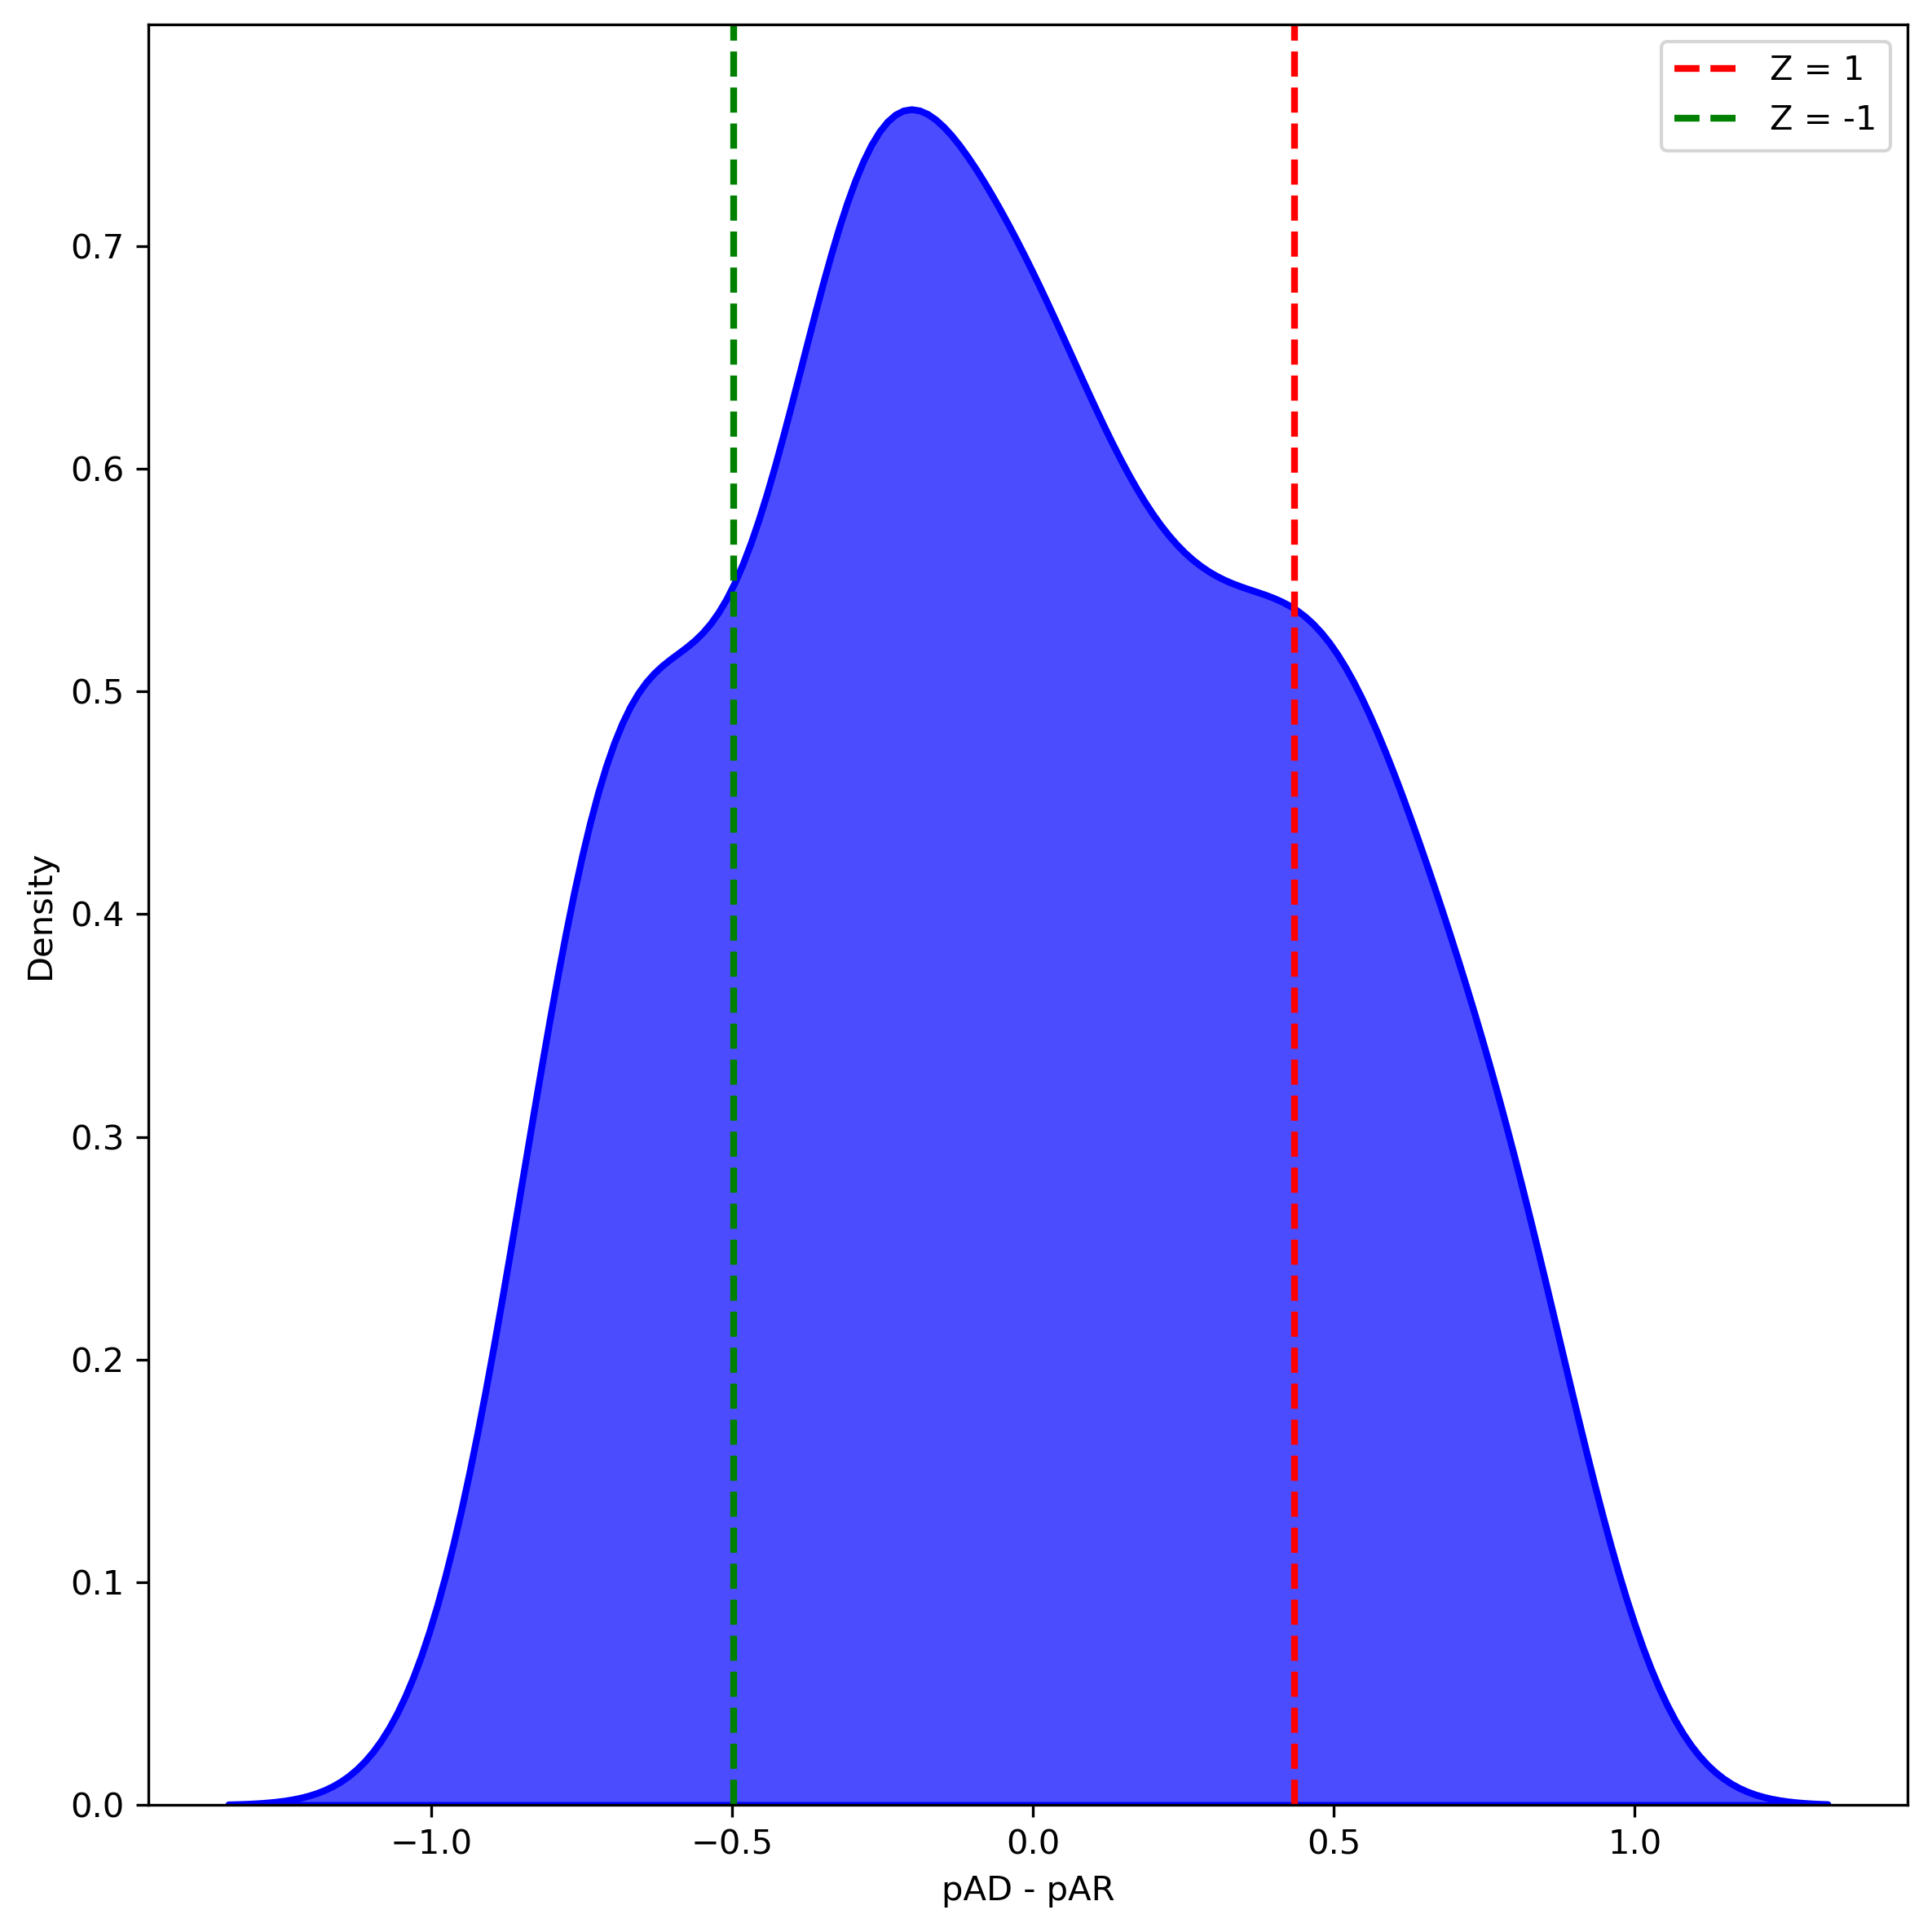

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming prob_diff_np is your data, and z2_value and z_minus_2_value are defined
# Creating a high-quality density plot with Seaborn
plt.figure(figsize=(8, 8), dpi=300)

# Using seaborn to create a density plot (KDE)
sns.kdeplot(prob_diff_np, fill=True, color='blue', alpha=0.7, linewidth=2)

# Add vertical lines for Z = 2 and Z = -2
plt.axvline(x=z2_value, color='red', linestyle='--', linewidth=2, label='Z = 1')
plt.axvline(x=z_minus_2_value, color='green', linestyle='--', linewidth=2, label='Z = -1')

# Add title and labels with larger font sizes
plt.xlabel('pAD - pAR')
plt.ylabel('Density')


# Tight layout for better spacing
plt.tight_layout()

# Add legend
plt.legend()

# Save the plot as a high-quality PNG file
#plt.savefig('../res/plots/test_pAD_minus_pAR_density.png', dpi=300)

# Show the plot
plt.show()


### Explain

In [39]:
from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer, GraphMaskExplainer

'''
explainer = Explainer(
    model=gcn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)'''


explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    node_mask_type='attributes',
    edge_mask_type=None,
    #threshold_config=dict(
    #    threshold_type='topk',
    #    value=30,
    #),
    
)

In [41]:
test_AD_explain = torch.zeros(data.x.shape[1])
test_AR_explain = torch.zeros(data.x.shape[1])

for index in top_AD_index:
    print(index)
    if torch.all(data.y[index] == torch.tensor([1, 0])):
        explanation = explainer(data.x, data.edge_index, index=torch.tensor(index))
        test_AD_explain += explanation.node_stores[0]['node_mask'].sum(dim=0) 
    else:
        print(f"predicted {all_probs[index]} but true label is {data.y[index]} ")
        
for index in top_AR_index:
    print(index)
    if torch.all(data.y[index] == torch.tensor([0, 1])):
        explanation = explainer(data.x, data.edge_index, index=torch.tensor(index))
        test_AR_explain += explanation.node_stores[0]['node_mask'].sum(dim=0) 
    else:
        print(f"predicted {all_probs[index]} but true label is {data.y[index]} ")

22
predicted tensor([0.7353, 0.2795]) but true label is tensor([1., 1.]) 
86
137
144
predicted tensor([0.8481, 0.2011]) but true label is tensor([1., 1.]) 
332
predicted tensor([0.7527, 0.2659]) but true label is tensor([0., 1.]) 
384
420
596
607
648
661
762
878
predicted tensor([0.8615, 0.1859]) but true label is tensor([1., 1.]) 
889
951
969
973
976
1273
1277
1303
1363
1386
1407
1521
1619
predicted tensor([0.7858, 0.2013]) but true label is tensor([0., 1.]) 
1664
1670
predicted tensor([0.7472, 0.2476]) but true label is tensor([1., 1.]) 
1727
predicted tensor([0.7474, 0.2986]) but true label is tensor([0., 1.]) 
1791
predicted tensor([0.7596, 0.2395]) but true label is tensor([1., 1.]) 
1818
1886
predicted tensor([0.8361, 0.1842]) but true label is tensor([1., 1.]) 
1895
2158
2179
predicted tensor([0.9180, 0.0834]) but true label is tensor([0., 1.]) 
2229
predicted tensor([0.9009, 0.1155]) but true label is tensor([1., 1.]) 
2237
predicted tensor([0.8614, 0.1710]) but true label is t

In [356]:
'''AD_explain_values, AD_explain_indices = torch.topk(test_AD_explain, 20)
AR_explain_values, AR_explain_indices = torch.topk(test_AR_explain, 20)'''

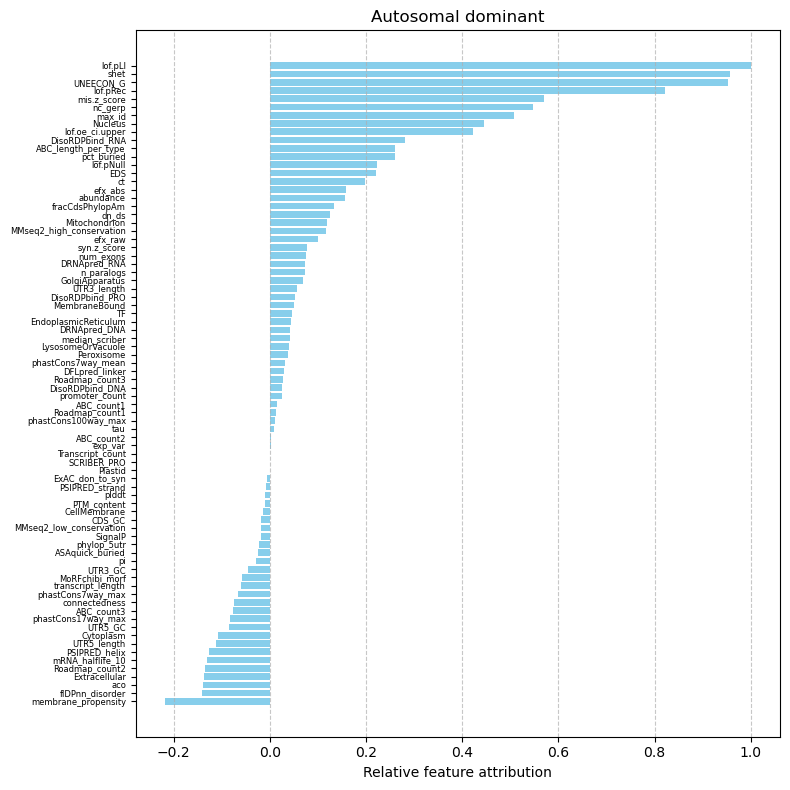

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists (replace with your actual data)
names = selected_corr_feature_names #selected_feature_names[AD_explain_indices]
values = test_AD_explain #AD_explain_values

# Normalize the values by dividing by the maximum value
max_value = max(values)
normalized_values = [v / max_value for v in values]

# Sort the data by the normalized values
sorted_indices = np.argsort(normalized_values)
sorted_names = [names[i] for i in sorted_indices]
sorted_values = [normalized_values[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(sorted_names, sorted_values, color='skyblue')
plt.xlabel('Relative feature attribution')
plt.title('Autosomal dominant')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='y', labelsize=6) 

# Ensure high quality plot for publication
plt.tight_layout()
plt.savefig('../res/plots/AD_featire_importance.png', dpi=300)
plt.show()


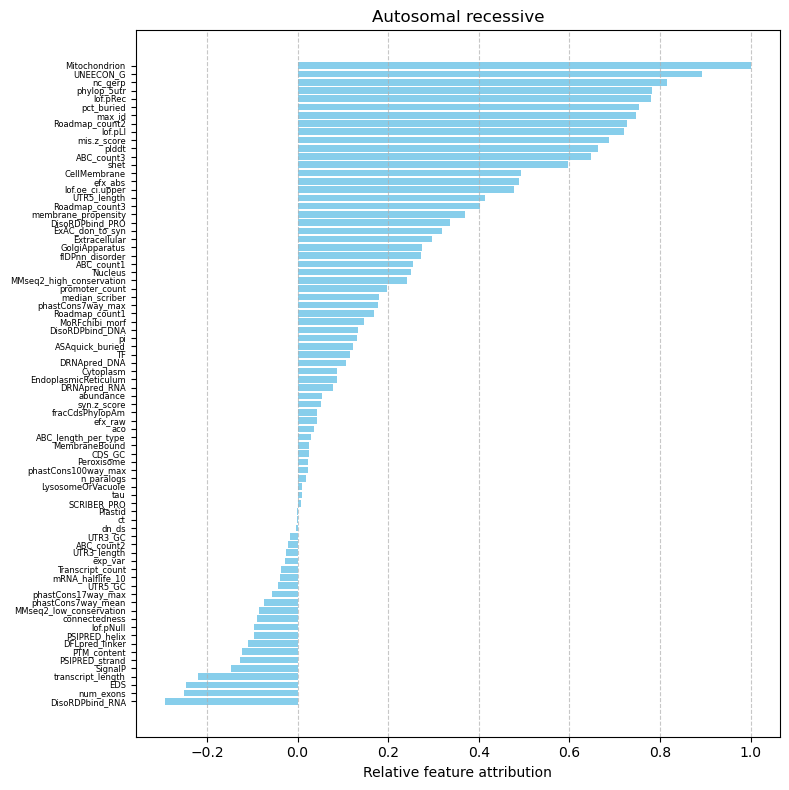

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists (replace with your actual data)
names = selected_corr_feature_names #selected_feature_names[AD_explain_indices]
values = test_AR_explain #AD_explain_values

# Normalize the values by dividing by the maximum value
max_value = max(values)
normalized_values = [v / max_value for v in values]

# Sort the data by the normalized values
sorted_indices = np.argsort(normalized_values)
sorted_names = [names[i] for i in sorted_indices]
sorted_values = [normalized_values[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(sorted_names, sorted_values, color='skyblue')
plt.xlabel('Relative feature attribution')
plt.title('Autosomal recessive')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='y', labelsize=6) 

# Ensure high quality plot for publication
plt.tight_layout()
plt.savefig('../res/plots/AR_featire_importance.png', dpi=300)
plt.show()

### Proteome wide prediction

In [300]:
index_to_node = {v: k for k, v in node_idx_map.items()}

In [301]:
all_nonX_proteins = df_ADAR_notavailable['uniprot_ids'].values.tolist() + df_ADAR['uniprot_ids'].values.tolist()
all_nonX_proteins[:5]

['P04217', 'P01023', 'U3KPV4', 'Q9NPC4', 'Q9UNA3']

In [302]:
all_probs_df = pd.DataFrame({
    'pAD': all_probs.numpy()[:, 0],
    'pAR': all_probs.numpy()[:, 1],
    'UniprotEntry': list(node_idx_map.keys())
})

all_probs_df = all_probs_df[all_probs_df['UniprotEntry'].isin(all_nonX_proteins)]

all_probs_df.to_csv("../res/data/all_probs_df.tsv", sep='\t')
all_probs_df

,pAD,pAR,UniprotEntry
0,0.643632,0.445027,Q14315
1,0.789829,0.227079,P45985
2,0.448042,0.696418,Q92629
3,0.314086,0.789687,Q13326
4,0.573700,0.504479,Q9NP98
...,...,...,...
17241,0.141597,0.471952,A0A286YF01
17244,0.050174,0.909432,A0A1B0GVY4
17245,0.050174,0.909432,A0A2R8YCJ5
17246,0.510996,0.674568,Q96RD0


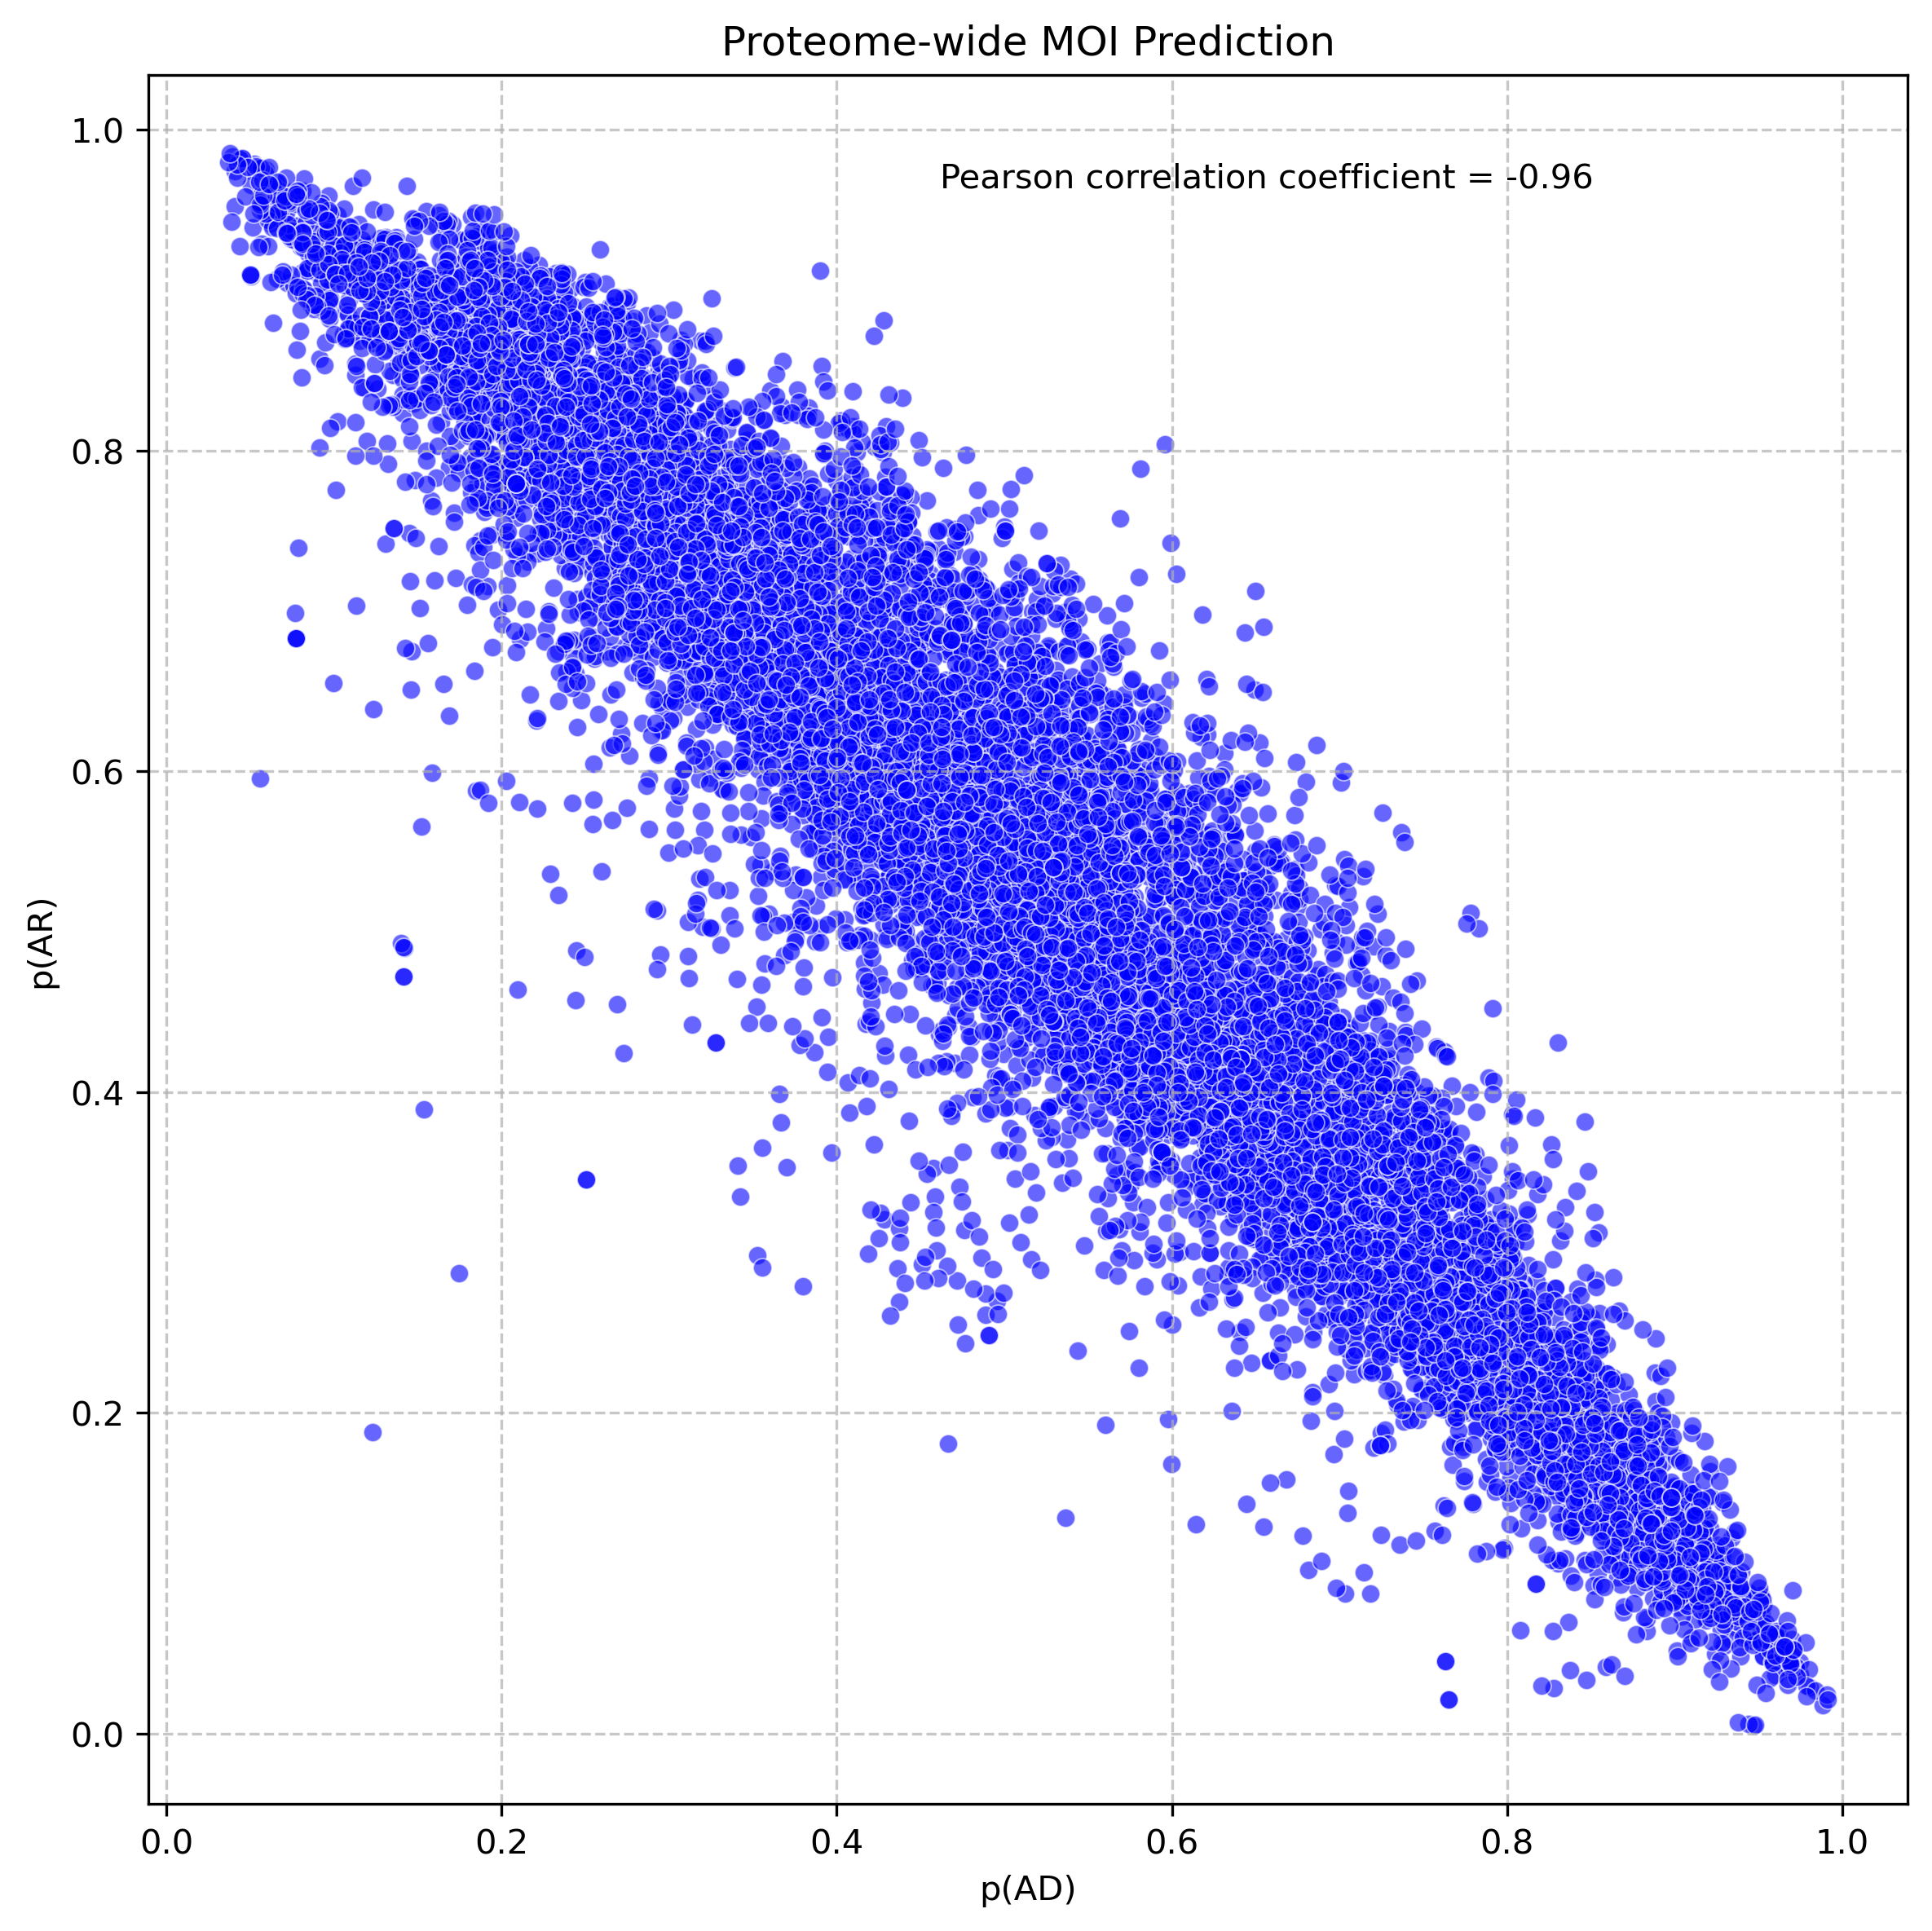

In [367]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Compute the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(all_probs[:, 0], all_probs[:, 1])

# Creating a high-quality scatter plot using seaborn
plt.figure(figsize=(8, 8), dpi=300)

# Using seaborn's scatterplot function for better styling
sns.scatterplot(x=all_probs[:, 0], y=all_probs[:, 1], alpha=0.6, s=30, color='blue')

# Adding labels and title with larger font sizes
plt.xlabel('p(AD)')
plt.ylabel('p(AR)')
plt.title('Proteome-wide MOI Prediction')

# Adding gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding correlation coefficient and p-value to the plot
plt.text(0.45, 0.95, f'Pearson correlation coefficient = {correlation:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

# Saving the plot as a high-quality PNG file
plt.tight_layout()
plt.savefig('../res/plots/AD_vs_AR_high_quality.png', dpi=300)

# Show the plot
plt.show()



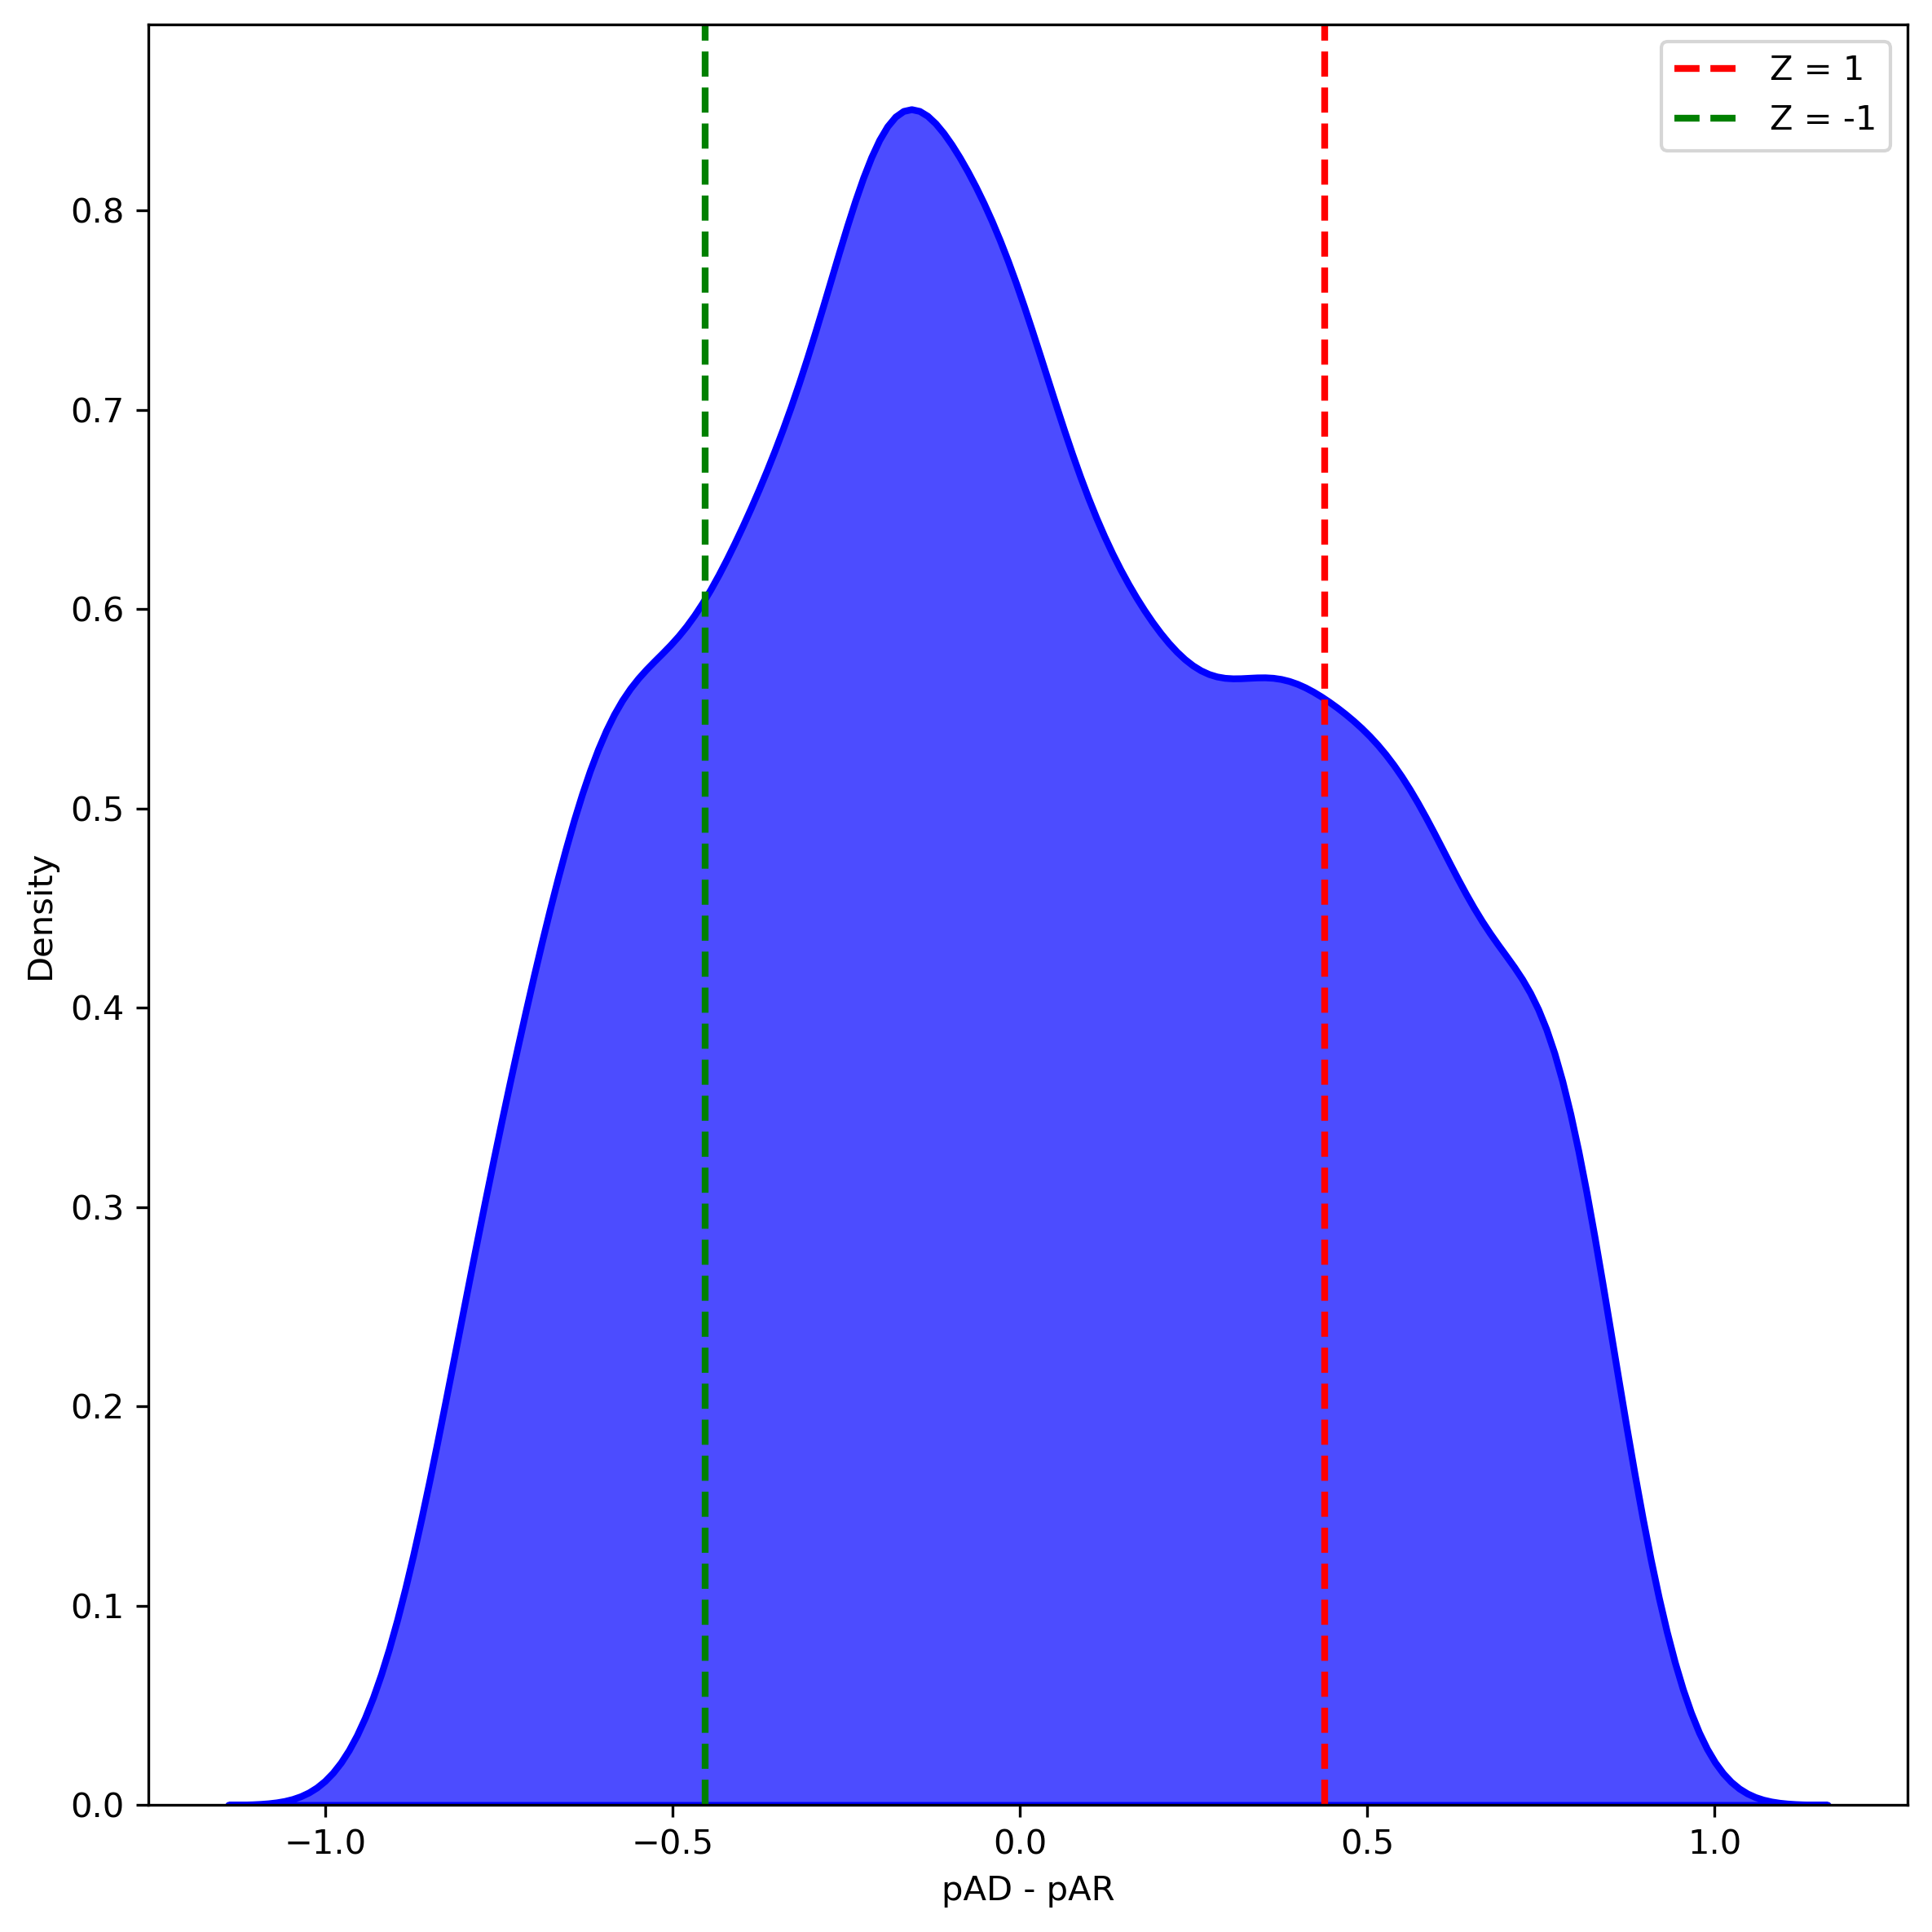

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the difference (pAD - pAR)
all_probs_df['pAD_minus_pAR'] = all_probs_df['pAD'] - all_probs_df['pAR']

# Calculate mean and standard deviation of "pAD - pAR"
mean_value = all_probs_df['pAD_minus_pAR'].mean()
std_dev = all_probs_df['pAD_minus_pAR'].std()

# Calculate the values corresponding to Z = 2 and Z = -2
z2_value = mean_value + 1 * std_dev
z_minus_2_value = mean_value - 1 * std_dev

# Plot the density with high-quality settings
plt.figure(figsize=(8, 8), dpi=300)

# Use seaborn to create a density plot (KDE)
sns.kdeplot(all_probs_df['pAD_minus_pAR'], fill=True, color='blue', alpha=0.7, linewidth=2)

# Add vertical lines for Z = 2 and Z = -2
plt.axvline(x=z2_value, color='red', linestyle='--', linewidth=2, label='Z = 1')
plt.axvline(x=z_minus_2_value, color='green', linestyle='--', linewidth=2, label='Z = -1')

# Add title and labels with larger font sizes
plt.xlabel('pAD - pAR')
plt.ylabel('Density')

# Tight layout for better spacing
plt.tight_layout()
plt.legend()

# Save the plot as high-quality PNG
#plt.savefig('../res/plots/pAD_minus_pAR.png', dpi=300)

# Show the plot
plt.show()

In [5]:
AD_proteins = all_probs_df[all_probs_df["pAD_minus_pAR"]>z2_value]["UniprotEntry"].values.tolist()
AR_proteins = all_probs_df[all_probs_df["pAD_minus_pAR"]<z_minus_2_value]["UniprotEntry"].values.tolist()
len(AD_proteins), len(AR_proteins)

(3285, 3038)

### pathways

In [8]:
# Create a new DataFrame by concatenating the SYMBOL1-uniprot_ids1 and SYMBOL2-uniprot_ids2 pairs
uniprot_to_symbol_df = pd.concat([
    ppi[['SYMBOL1', 'uniprot_ids1']].rename(columns={'SYMBOL1': 'SYMBOL', 'uniprot_ids1': 'uniprot_id'}),
    ppi[['SYMBOL2', 'uniprot_ids2']].rename(columns={'SYMBOL2': 'SYMBOL', 'uniprot_ids2': 'uniprot_id'})
])

# Reset index for a clean DataFrame
uniprot_to_symbol_df = uniprot_to_symbol_df.drop_duplicates().reset_index(drop=True)
uniprot_to_symbol_df

,SYMBOL,uniprot_id
0,FLNC,Q14315
1,FBXL22,Q6P050
2,FBXW11,Q9UKB1
3,AGR2,O95994
4,ANK3,Q12955
...,...,...
17339,SMIM36,A0A1B0GVT2
17340,TMDD1,P0DPE3
17341,TEX53,A0A1B0GU33
17342,SCYGR7,A0A286YF01


In [9]:
AD_genes = uniprot_to_symbol_df[uniprot_to_symbol_df["uniprot_id"].isin(AD_proteins)]["SYMBOL"].values.tolist()
AR_genes = uniprot_to_symbol_df[uniprot_to_symbol_df["uniprot_id"].isin(AR_proteins)]["SYMBOL"].values.tolist()

In [10]:
import textwrap

def split_long_sentences(text, width=70):
    return '\n'.join(textwrap.wrap(text, width))

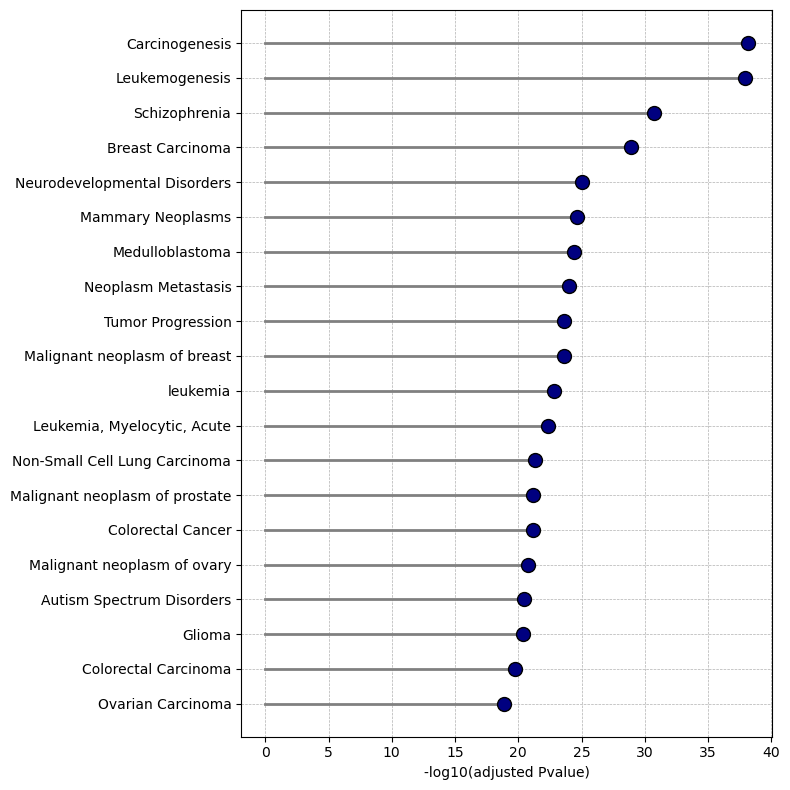

In [14]:
import gseapy as gp
import numpy as np

enr = gp.enrichr(gene_list=list(AD_genes),
                 gene_sets=['DisGeNET'],
                 #gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                 organism='human',
                 background=uniprot_to_symbol_df['SYMBOL'].values.tolist()
                )

enr.results[enr.results['Adjusted P-value'] <= 0.05]

top10 = enr.results[enr.results['Adjusted P-value'] <= 0.05]
top10 = top10.iloc[0:20, :]
top10['-log10(P-value)'] = -np.log10(top10['Adjusted P-value'])
top10 = top10.sort_values('-log10(P-value)', ascending=True)
#top10['Term'] = top10['Term'].str.replace(r' R-HSA-\d+$', '', regex=True)
top10['Term'] = top10['Term'].apply(split_long_sentences)

# Plotting
plt.figure(figsize=(8, 8))

for i in range(len(top10)):
    plt.plot([0, top10['-log10(P-value)'].iloc[i]], [top10['Term'].iloc[i], top10['Term'].iloc[i]], color='gray', linestyle='-', linewidth=2)  # Line part of lollipop
    plt.scatter(top10['-log10(P-value)'].iloc[i], top10['Term'].iloc[i], color='navy', s=100, edgecolor='black', zorder=5)  # Dot part of lollipop

plt.xlabel('-log10(adjusted Pvalue)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('../res/plots/AD_pathways.png', format='png', dpi=300)
plt.show()

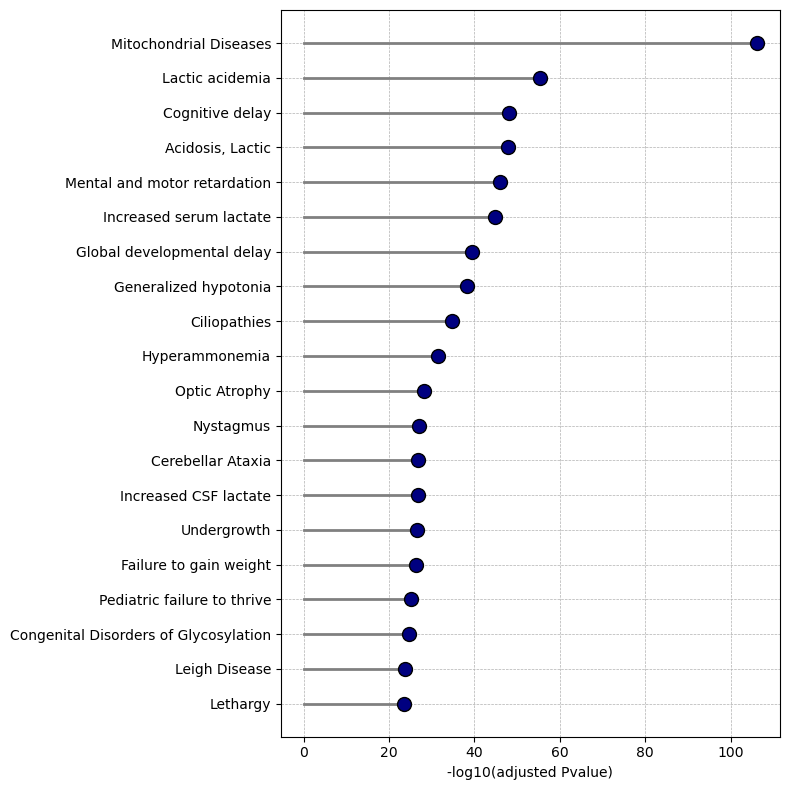

In [15]:
import gseapy as gp

enr = gp.enrichr(gene_list=list(AR_genes),
                 gene_sets=['DisGeNET'],
                 #gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                 organism='human',
                 background=uniprot_to_symbol_df['SYMBOL'].values.tolist()
                )

enr.results[enr.results['Adjusted P-value'] <= 0.05]

top10 = enr.results[enr.results['Adjusted P-value'] <= 0.05]
top10 = top10.iloc[0:20, :]
top10['-log10(P-value)'] = -np.log10(top10['Adjusted P-value'])
top10 = top10.sort_values('-log10(P-value)', ascending=True)
top10['Term'] = top10['Term'].str.replace(r' R-HSA-\d+$', '', regex=True)
top10['Term'] = top10['Term'].apply(split_long_sentences)

# Plotting
plt.figure(figsize=(8, 8))

for i in range(len(top10)):
    plt.plot([0, top10['-log10(P-value)'].iloc[i]], [top10['Term'].iloc[i], top10['Term'].iloc[i]], color='gray', linestyle='-', linewidth=2)  # Line part of lollipop
    plt.scatter(top10['-log10(P-value)'].iloc[i], top10['Term'].iloc[i], color='navy', s=100, edgecolor='black', zorder=5)  # Dot part of lollipop

plt.xlabel('-log10(adjusted Pvalue)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('../res/plots/AR_pathways.png', format='png', dpi=300)
plt.show()

### Explore

In [42]:
df_ADAR_features = df_ADAR.join(merged_features, how="left", on="uniprot_ids")
df_ADAR_features

,symbol,uniprot_ids,chr,AD,AR,flDPnn_disorder,PSIPRED_helix,PSIPRED_strand,PSIPRED_coil,MMseq2_low_conservation,...,ct,phylop_5utr,ExAC_don_to_syn,mRNA_halflife_10,lof.pLI,lof.pNull,lof.pRec,lof.oe_ci.upper,mis.z_score,syn.z_score
0,A1CF,Q9NQ94,10,1,1,0.025,0.306,0.214,0.480,0.01,...,0.0,0.354861,0.000000,0.0,7.656000e-10,1.960600e-03,9.980400e-01,0.825,1.23730,0.017838
1,A2ML1,A8K2U0,12,1,0,0.000,0.243,0.292,0.465,0.10,...,0.0,0.133771,0.069959,0.0,1.712700e-40,1.011000e-01,8.989000e-01,0.953,1.65710,0.951210
2,AAAS,Q9NRG9,12,0,1,0.104,0.201,0.236,0.563,0.14,...,1.0,0.179612,0.053191,0.0,8.923100e-16,1.497600e-02,9.850200e-01,0.921,0.88677,0.305120
3,AAGAB,Q6PD74,15,1,0,0.305,0.365,0.162,0.473,0.11,...,0.0,-0.036104,0.019231,0.0,1.570600e-08,1.983500e-01,8.016500e-01,1.156,-1.00370,-0.008987
4,AARS1,P49588,16,1,1,0.000,0.443,0.159,0.398,0.06,...,0.0,NaN,NaN,NaN,4.040000e-14,8.095200e-05,9.999200e-01,0.772,1.04530,-0.004092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4717,ZP2,Q05996,16,0,1,0.055,0.205,0.314,0.481,0.07,...,0.0,-0.111826,0.055556,0.0,3.009700e-09,9.267600e-05,9.999100e-01,0.736,0.57259,-0.752670
4718,ZP3,P21754,7,1,0,0.071,0.196,0.278,0.526,0.08,...,0.0,-0.163655,0.042553,0.0,1.184500e-05,4.965300e-02,9.503300e-01,0.995,0.31310,-0.915860
4719,ZPR1,O75312,11,0,1,0.277,0.336,0.133,0.531,0.07,...,1.0,0.102632,0.029851,0.0,7.025300e-07,3.154200e-03,9.968500e-01,0.815,0.73285,0.700630
4720,ZSWIM6,Q9HCJ5,5,1,0,0.050,0.533,0.060,0.407,0.12,...,1.0,1.398299,0.000000,0.0,1.000000e+00,1.211100e-29,1.251900e-17,0.146,3.28920,-0.455680


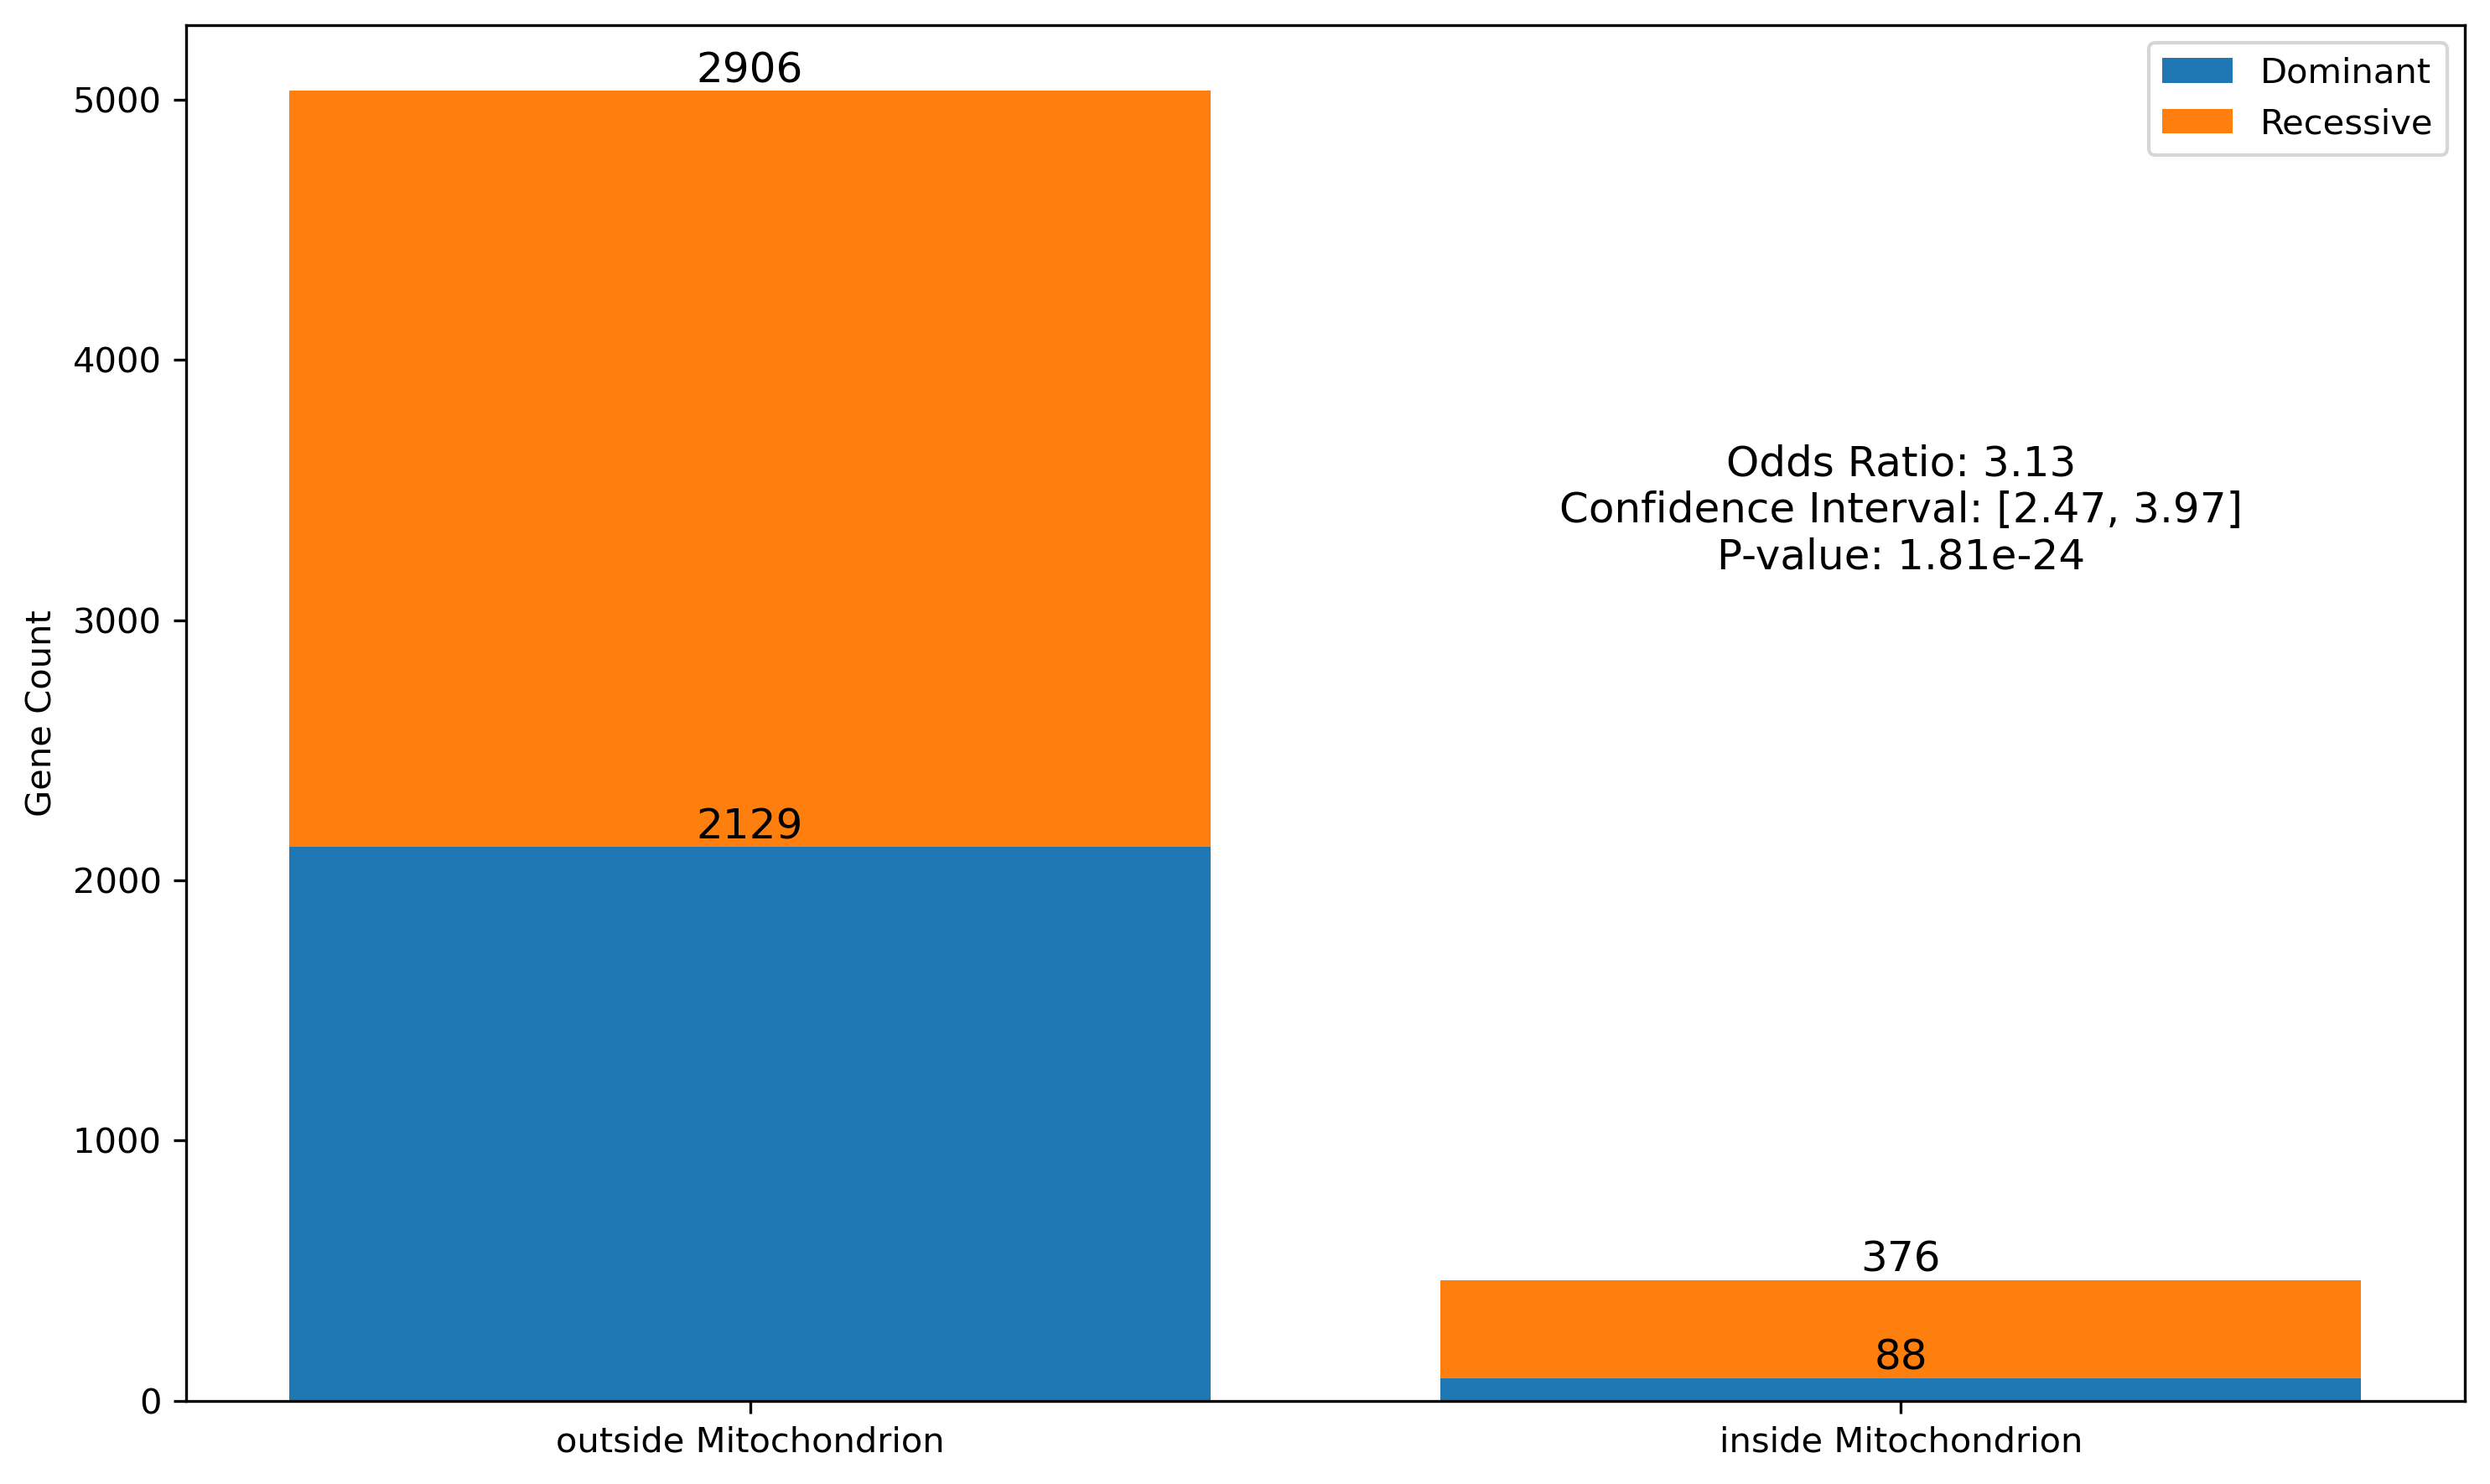

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.contingency_tables import Table2x2

# Assuming df_ADAR_features is a pandas DataFrame with 'Mitochondrion', 'AD', and 'AR' columns
nucleus_group = df_ADAR_features.groupby('Mitochondrion').sum()

# Calculating odds ratio
AR_inside = nucleus_group['AR'][1]
AD_inside = nucleus_group['AD'][1]
AR_outside = nucleus_group['AR'][0]
AD_outside = nucleus_group['AD'][0]

# Contingency table for Fisher's Exact Test
contingency_table = [[AR_inside, AD_inside], [AR_outside, AD_outside]]
_, p_value = fisher_exact(contingency_table)

# Odds ratio formula
#odds_ratio = (AR_inside / AR_outside) / (AD_inside / AD_outside)
table = Table2x2(np.array(contingency_table))
odds_ratio = table.oddsratio
ci_low, ci_high = table.oddsratio_confint()


# Data for the plot
locations = ['outside Mitochondrion', 'inside Mitochondrion']
dominant = [nucleus_group['AD'][0], nucleus_group['AD'][1]]
recessive = [nucleus_group['AR'][0], nucleus_group['AR'][1]]

# Creating the stacked bar plot
plt.figure(figsize=(10, 6), dpi=300)
bars1 = plt.bar(locations, dominant, label='Dominant', )
bars2 = plt.bar(locations, recessive, bottom=dominant, label='Recessive')

# Adding numbers on top of each dominant bar
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12)

# Adding numbers on top of each recessive bar (stacked)
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    plt.text(bar2.get_x() + bar2.get_width() / 2, height1 + height2, f'{int(height2)}', ha='center', va='bottom', fontsize=12)

# Adding labels and title
plt.ylabel('Gene Count')
plt.legend()

# Display odds ratio and p-value on the plot
plt.text(1, max(dominant + recessive) * 1.1, 
         f'Odds Ratio: {odds_ratio:.2f}\nConfidence Interval: [{ci_low:.2f}, {ci_high:.2f}]\nP-value: {p_value:.2e}', 
         ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../res/plots/AD_AR_Mitochondrion_OddsRatio_stackedBarplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [80]:
contingency_table

[[376, 88], [2906, 2129]]

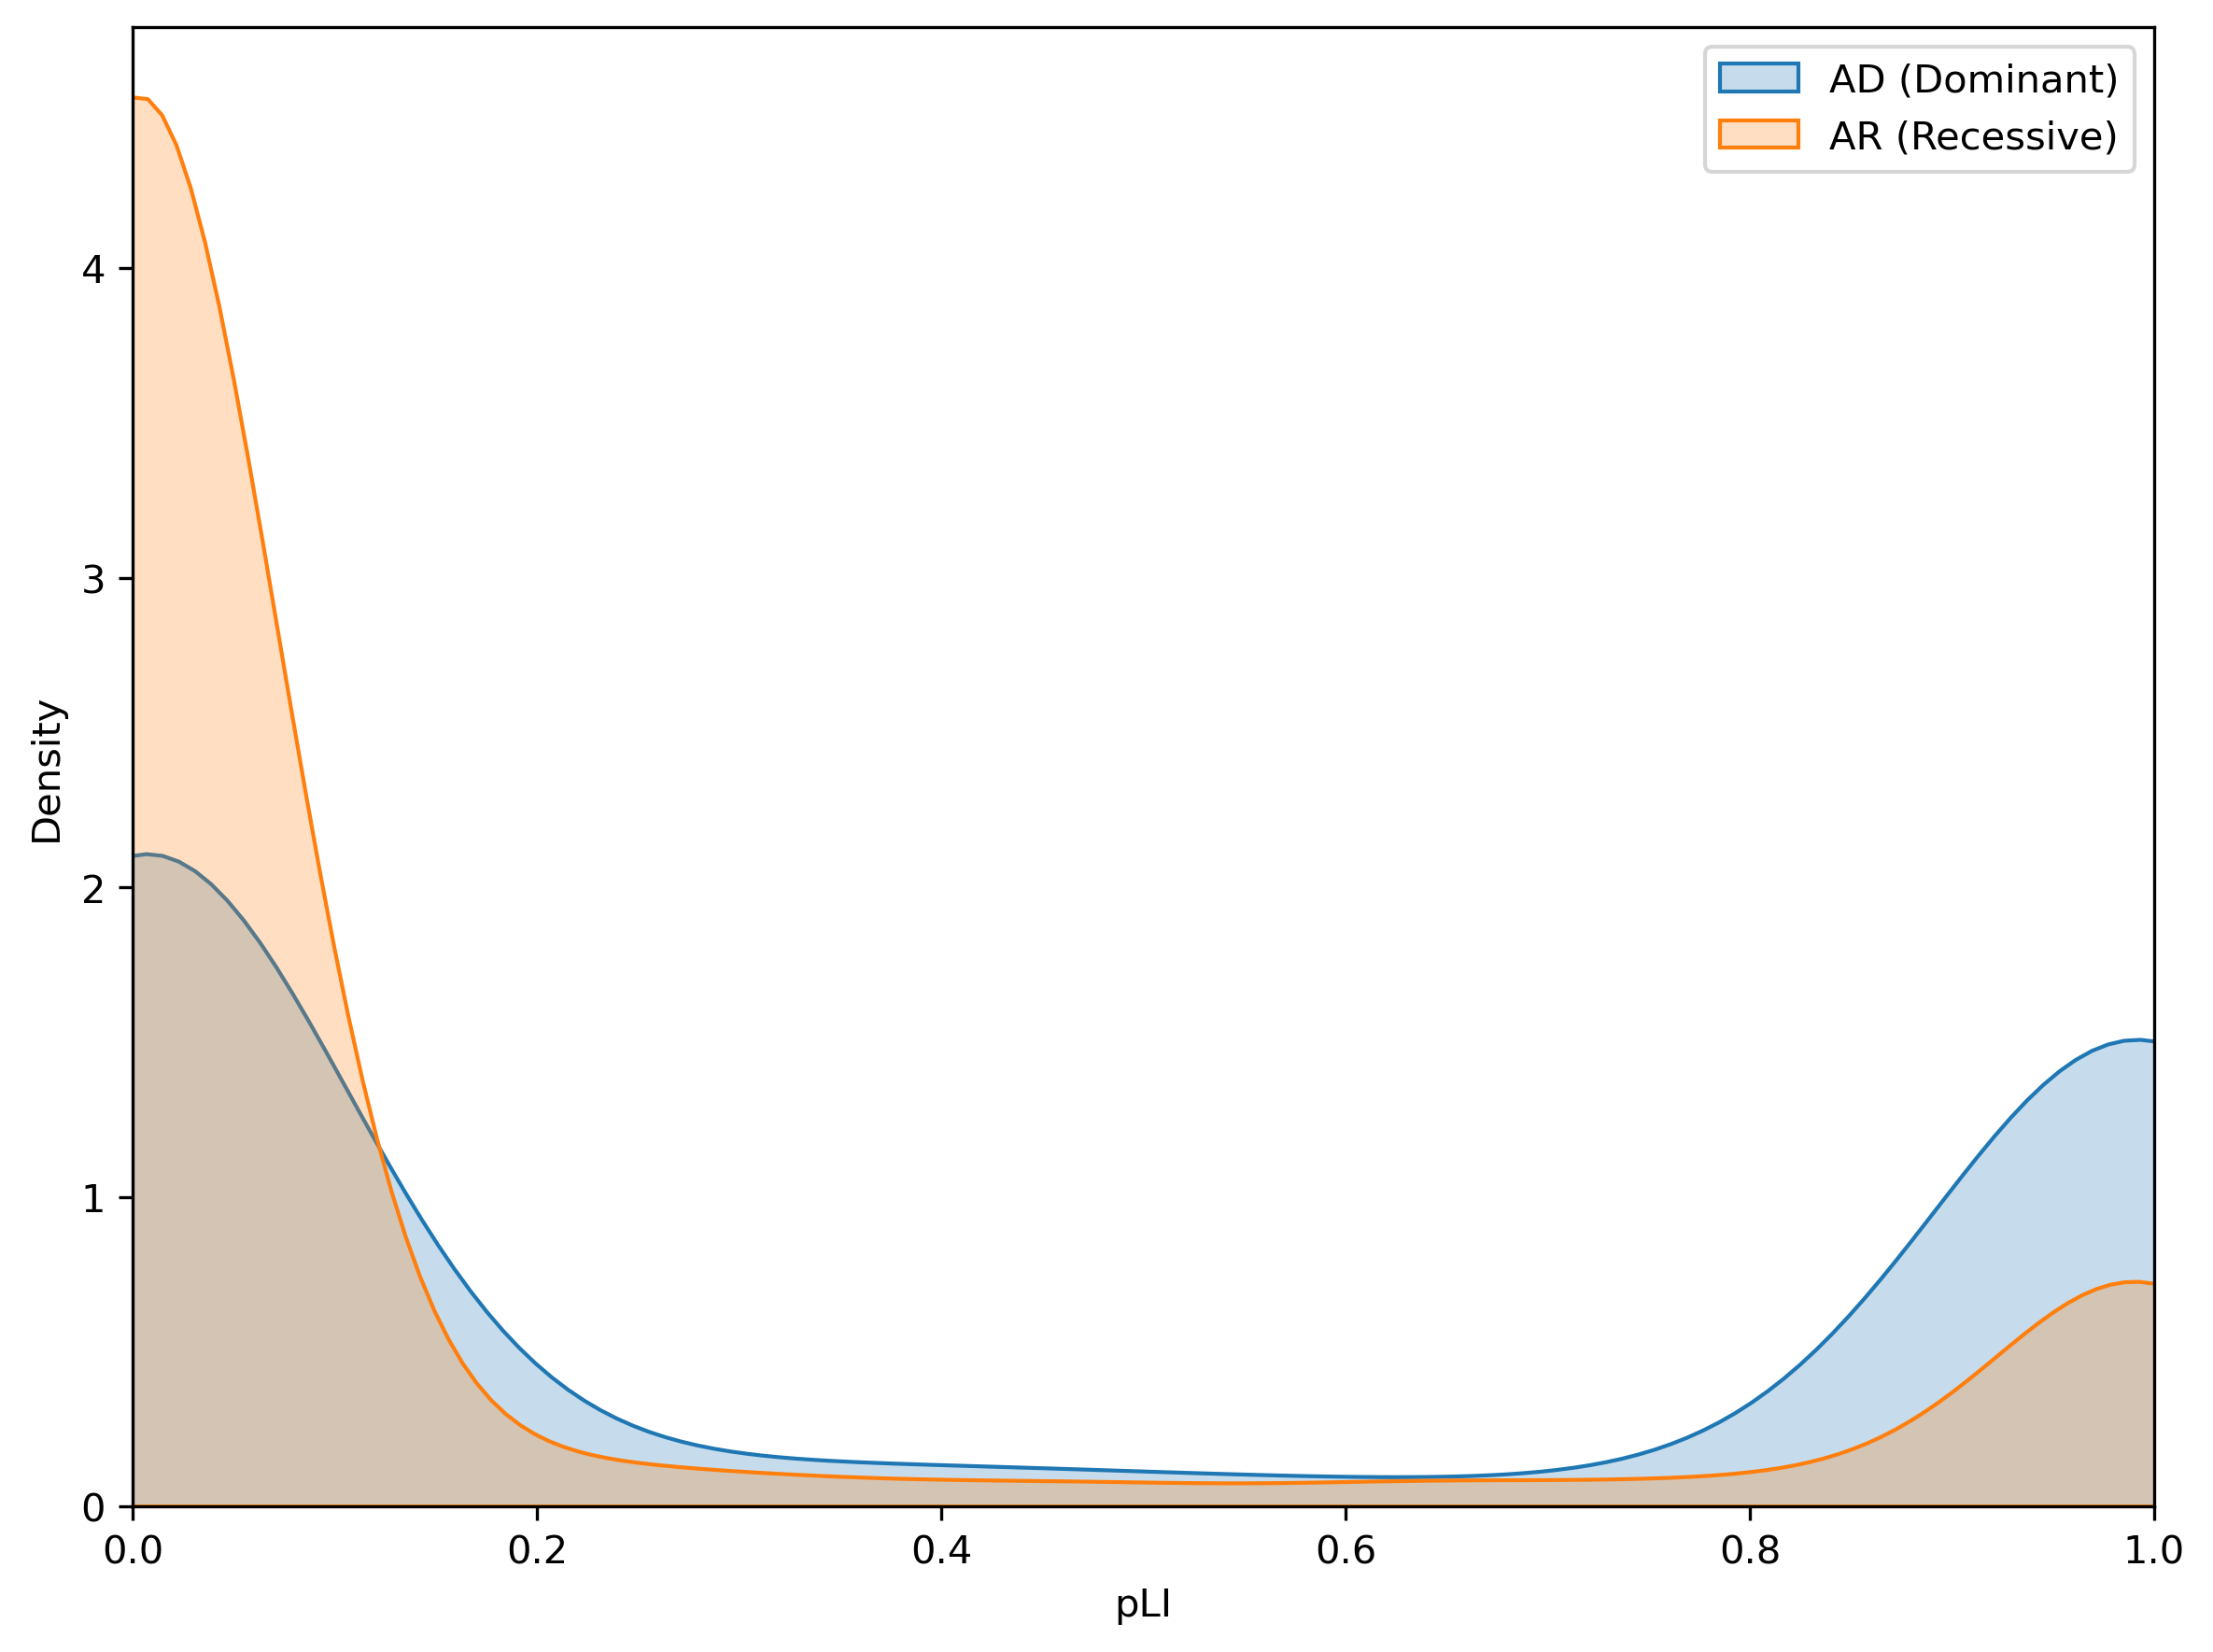

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure for density plot
plt.figure(figsize=(8, 6), dpi=300)

# Plot density for AD (Dominant genes)
sns.kdeplot(df_ADAR_features[df_ADAR_features['AD'] == 1]['lof.pLI'], label='AD (Dominant)', color='#1f77b4', fill=True)

# Plot density for AR (Recessive genes)
sns.kdeplot(df_ADAR_features[df_ADAR_features['AR'] == 1]['lof.pLI'], label='AR (Recessive)', color='#ff7f0e', fill=True)

# Set x-axis limits to 0 and 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('pLI')
plt.ylabel('Density')

# Show legend
plt.legend()

# Save the plot as high quality for publication
plt.tight_layout()
plt.savefig('../res/plots/AD_AR_lof.pLI_DensityPlot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


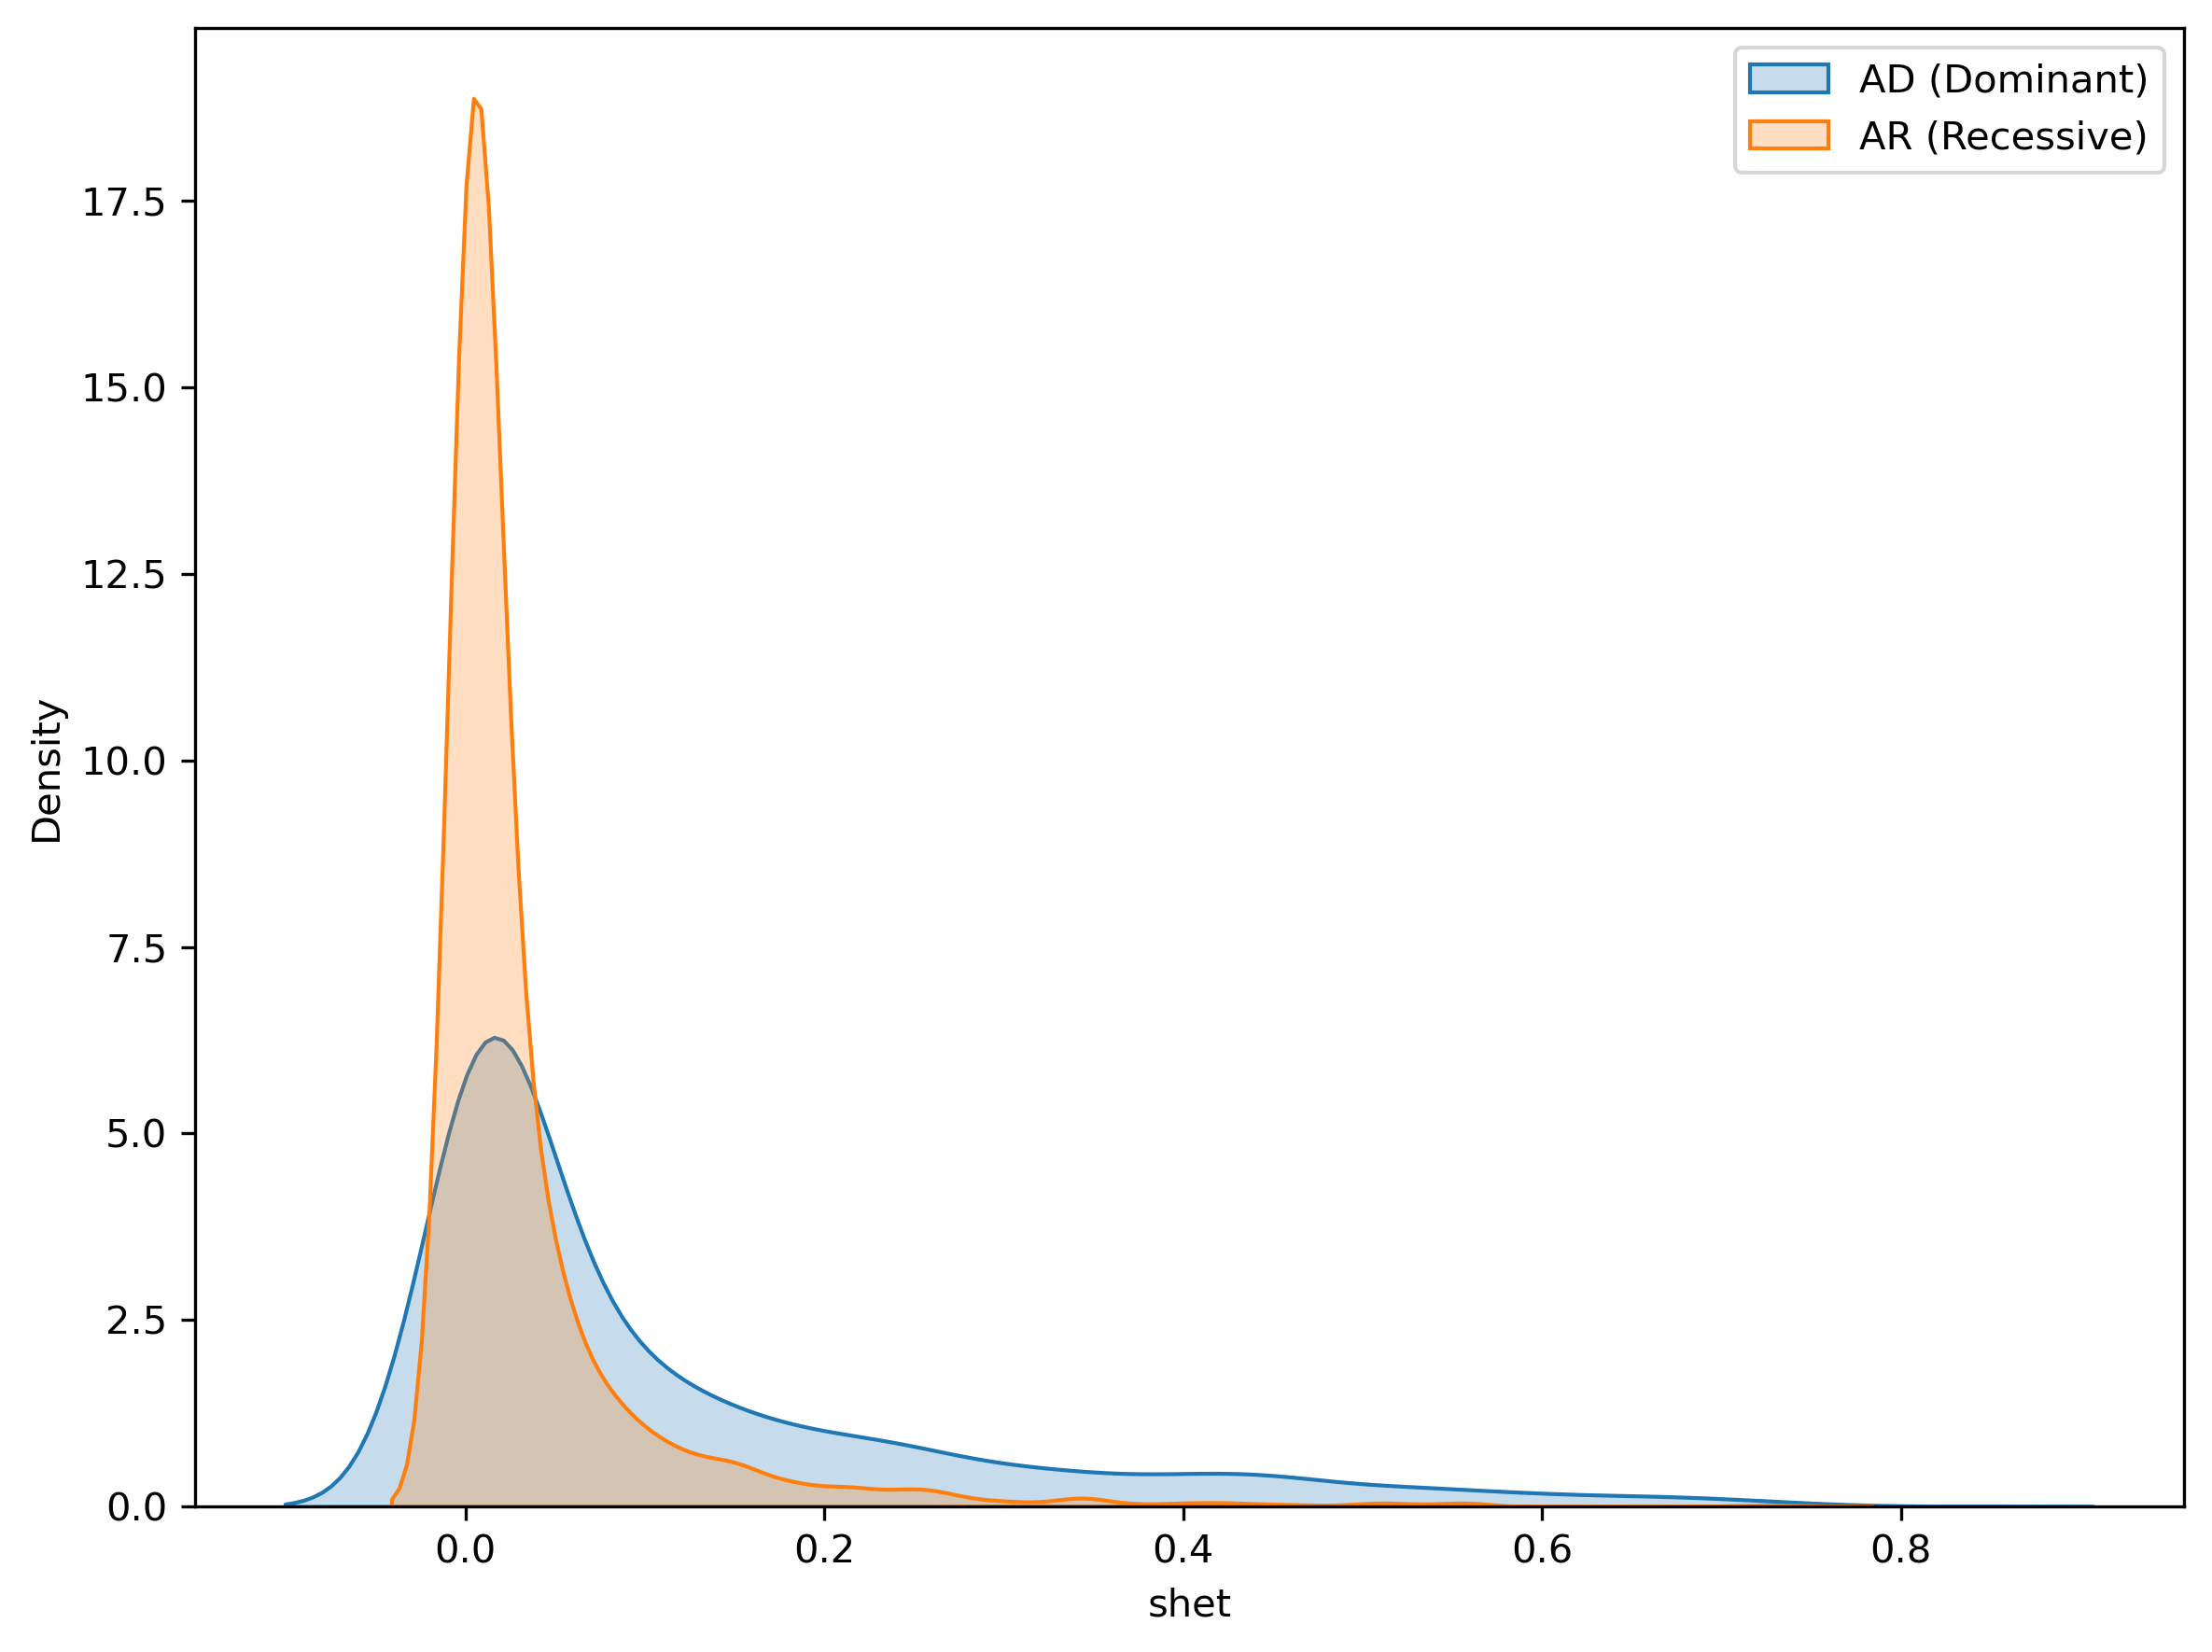

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set up figure for density plot
plt.figure(figsize=(8, 6), dpi=300)

# Plot density for AD (Dominant genes)
sns.kdeplot(df_ADAR_features[df_ADAR_features['AD'] == 1]['shet'], label='AD (Dominant)', color='#1f77b4', fill=True)

# Plot density for AR (Recessive genes)
sns.kdeplot(df_ADAR_features[df_ADAR_features['AR'] == 1]['shet'], label='AR (Recessive)', color='#ff7f0e', fill=True)

# Add labels and title
plt.xlabel('shet')
plt.ylabel('Density')

# Show legend
plt.legend()

# Save the plot as high quality for publication
plt.tight_layout()
plt.savefig('../res/plots/AD_AR_shet_DensityPlot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


### Domino

In [47]:
test_proteins = [protein for protein, idx in node_idx_map.items() if test_mask[idx]]
test_df_ADAR = df_ADAR[df_ADAR['uniprot_ids'].isin(test_proteins)]
test_df_ADAR

,symbol,uniprot_ids,chr,AD,AR
24,ABCC9,O60706,12,1,0
35,ABL1,P00519,9,1,1
53,ACOT12,Q8WYK0,5,0,1
65,ACTG1,P63261,17,1,0
78,ACY1,Q03154,3,0,1
...,...,...,...,...,...
4702,ZNF384,Q8TF68,12,0,1
4703,ZNF407,Q9C0G0,18,0,1
4711,ZNF687,Q8N1G0,1,1,0
4715,ZNHIT3,Q15649,17,0,1


In [48]:
all_domino_preds = pd.read_csv("../data/MOI/domino/all_domino_preds.tsv", sep='\t')
all_domino_preds

,symbol,pAD,uniprot_ids
0,A1BG,0.160868,P04217
1,A1CF,0.095357,Q9NQ94
2,A2M,0.213642,P01023
3,A2ML1,0.092256,A8K2U0
4,A3GALT2,0.202530,U3KPV4
...,...,...,...
17893,ZYG11A,0.088915,Q6WRX3
17894,ZYG11B,0.773819,Q9C0D3
17895,ZYX,0.789162,Q15942
17896,ZZEF1,0.407334,O43149


In [49]:
domino_train = pd.read_csv('../data/MOI/domino/domino_training.tsv', sep='\t')
domino_train

,Gene_name,Inheritance_mode,LDA_score,uniprot_ids
0,AAGAB,AD,1.340610,Q6PD74
1,AARS2,AR,1.063910,Q5JTZ9
2,ABCA12,AR,0.977980,Q86UK0
3,ABCB11,AR,1.695119,O95342
4,ABCC2,AR,1.238396,Q92887
...,...,...,...,...
980,ZIC2,AD,-1.964628,O95409
981,ZMPSTE24,AR,0.647883,O75844
982,ZMYND10,AR,1.391903,O75800
983,ZNF513,AR,-1.232595,Q8N8E2


In [50]:
# add domino scores to test_df
test_df_ADAR_domino = test_df_ADAR.merge(all_domino_preds[['symbol', 'pAD']], how='left')
test_df_ADAR_domino

,symbol,uniprot_ids,chr,AD,AR,pAD
0,ABCC9,O60706,12,1,0,0.286221
1,ABL1,P00519,9,1,1,0.999533
2,ACOT12,Q8WYK0,5,0,1,0.109980
3,ACTG1,P63261,17,1,0,0.958950
4,ACY1,Q03154,3,0,1,0.049849
...,...,...,...,...,...,...
461,ZNF384,Q8TF68,12,0,1,0.944032
462,ZNF407,Q9C0G0,18,0,1,0.167873
463,ZNF687,Q8N1G0,1,1,0,0.648729
464,ZNHIT3,Q15649,17,0,1,0.124231


In [51]:
# remove domino train proteins from test_df
test_df_ADAR_domino_notrain = test_df_ADAR_domino[~test_df_ADAR_domino['symbol'].isin(domino_train['Gene_name'].values.tolist())]
test_df_ADAR_domino_notrain

,symbol,uniprot_ids,chr,AD,AR,pAD
1,ABL1,P00519,9,1,1,0.999533
2,ACOT12,Q8WYK0,5,0,1,0.109980
3,ACTG1,P63261,17,1,0,0.958950
4,ACY1,Q03154,3,0,1,0.049849
5,ADH1C,P00326,4,1,0,0.150753
...,...,...,...,...,...,...
461,ZNF384,Q8TF68,12,0,1,0.944032
462,ZNF407,Q9C0G0,18,0,1,0.167873
463,ZNF687,Q8N1G0,1,1,0,0.648729
464,ZNHIT3,Q15649,17,0,1,0.124231


In [52]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Assuming test_df_ADAR_domino_notrain is already defined and contains the necessary columns

# Generate predictions based on pAD thresholds
test_df_ADAR_domino_notrain['pred_AD'] = ((test_df_ADAR_domino_notrain['pAD'] > 0.6) | 
                                          ((test_df_ADAR_domino_notrain['pAD'] >= 0.4) & 
                                           (test_df_ADAR_domino_notrain['pAD'] <= 0.6))).astype(int)
test_df_ADAR_domino_notrain['pred_AR'] = ((test_df_ADAR_domino_notrain['pAD'] < 0.4) | 
                                          ((test_df_ADAR_domino_notrain['pAD'] >= 0.4) & 
                                           (test_df_ADAR_domino_notrain['pAD'] <= 0.6))).astype(int)

# True labels (multi-label: AD and AR)
y_true = test_df_ADAR_domino_notrain[['AD', 'AR']].values

# Predicted labels (multi-label: AD and AR)
y_pred = test_df_ADAR_domino_notrain[['pred_AD', 'pred_AR']].values

# Calculate precision, recall, and F1 for each class (AD, AR) as well as macro
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)  # Per class (AD, AR)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')  # Macro average

# Results for individual classes
print("AD - Precision:", precision[0], "Recall:", recall[0], "F1:", f1[0])
print("AR - Precision:", precision[1], "Recall:", recall[1], "F1:", f1[1])

# Results for macro average
print("Macro - Precision:", precision_macro, "Recall:", recall_macro, "F1:", f1_macro)


AD - Precision: 0.7266187050359713 Recall: 0.5580110497237569 F1: 0.63125
AR - Precision: 0.78515625 Recall: 0.788235294117647 F1: 0.786692759295499
Macro - Precision: 0.7558874775179856 Recall: 0.673123171920702 F1: 0.7089713796477495
